In [37]:
%load_ext autoreload
%autoreload 2

import  src.init
import  emcee
import  corner
import  numpy                   as np 
import  matplotlib.pyplot       as plt
from    math                    import inf
from    pathlib                 import Path
from    src.top_hat.montecarlo  import *
from src.top_hat.plot           import TopHatPlotter

plt.style.use('./configurations/style.mplstyle') #? Custom style, makes plots easier to read

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
datafiles   = Path("datafiles")
N_WALKERS   = 20

# Overall Universal Top Hat

In [39]:
# Model configuration
N_PARAMS        = 6
PARAM_NAMES     = ["A_index", "L_L0", "L_mu_E", "sigma_E", "theta_c_deg", "f_j"]
THETA_MAX_DEG   = 25 # degrees
MAX_FJ          = 10

def log_prior(thetas):
    A_index, L_L0, L_mu_E, sigma_E, theta_c_deg, fj = thetas
    
    if not (1.5 < A_index       < 12)               : return -inf
    if not (-2  < L_L0          < 6)                : return -inf
    if not (1   < L_mu_E        < 6.5)              : return -inf
    if not (0   < sigma_E       < 1.8)              : return -inf
    if not (0   < theta_c_deg   < THETA_MAX_DEG)    : return -inf
    if not (0   < fj            < MAX_FJ)           : return -inf

    return 0.0 # Uniform prior

def log_likelihood_default(thetas, params_in, distances, k_interpolator, n_events=10_000):
    """
    Simulate exactly n_years of GRB observations.
    """
    A_index, L_L0, L_mu_E, sigma_E, theta_c_deg, fj = thetas

    # Calculate epsilon from f_j and theta_c
    theta_c_rad             = np.radians(theta_c_deg)
    geometric_factor        = 1 - np.cos(theta_c_rad)
    epsilon                 = fj * geometric_factor

    gbm_eff                 = 0.6
    
    # Calculate expected number of GRBs for n_years
    n_years                 = params_in.triggered_years 
    intrinsic_rate_per_year = epsilon * len(params_in.z_arr) * gbm_eff
    expected_total_events   = intrinsic_rate_per_year * n_years
    
    if expected_total_events < 10:
        return -inf, -inf, -inf, -inf, -inf

    results                     = simplified_montecarlo(thetas, n_events, params_in, distances, k_interpolator)
    
    trigger_mask, analysis_mask = apply_detection_cuts(results["p_flux"], results["E_p_obs"])
    
    if np.sum(analysis_mask) <= 3:
        return -inf, -inf, -inf, -inf, -inf
    
    detected_events         = np.sum(trigger_mask)
    detection_efficiency    = detected_events / n_events

    predicted_detections    = expected_total_events * detection_efficiency

    # Observed detections in the actual catalog
    observed_detections     = params_in.yearly_rate * params_in.triggered_years

    l1                      = score_func_cvm(results["p_flux"][analysis_mask], params_in.pflux_data, params_in.rng)
    l2                      = score_func_cvm(results["E_p_obs"][analysis_mask], params_in.epeak_data, params_in.rng)
    l3                      = poiss_log(k=observed_detections, mu=predicted_detections)
    l4                      = np.sum(trigger_mask) / n_events
    
    return l1 + l2 + l3, l1, l2, l3, l4

def initialize_walkers(n_walkers):
    np.random.seed(42)
    return np.column_stack([
        np.random.uniform(2, 3, n_walkers),           # A_index
        np.random.uniform(2, 4.0, n_walkers),         # L_L0
        np.random.uniform(2.0, 4.0, n_walkers),       # L_mu_E
        np.random.uniform(0.2, 1, n_walkers),         # sigma_E
        np.random.uniform(1, 15, n_walkers),          # theta_c_deg ← NEW!
        np.random.uniform(0.5, 2, n_walkers),         # f_j ← NEW!
    ])

In [40]:
# Where to find the datafiles and save the outputs
output_dir_eps  = src.init.create_run_dir(f"Epsilon_test_flat_theta")
params = {
    "alpha"         : -0.67,    # 2/3 from synchrotron
    "beta_s"        : -2.59,    # Average value from GRBs
    "n"             : 2,        # Smoothly broken power law curvature
    "theta_c"       : 3.4,      # Ghirlanda half-angle of jet core (from GW170817)
    "theta_v_max"   : 10,       # Maximum viewing angle of the jet (in degrees)
    "z_model"      : 'fiducial_Hrad_A1.0'    #? Optional, model to use for redshift distribution
}
default_params, _, data_dict = src.init.initialize_simulation(datafiles, params=params) #? Catalogue data from fermi GBM

print(f"Total events in the catalogue: {len(default_params.pflux_data)}")

n_walkers       = 20
n_steps         = 60_000

k_interpolator  = create_k_interpolator()

log_likelihood_default_in = create_log_probability_function(
    log_prior_func          =   log_prior,
    log_likelihood_func     =   log_likelihood_default,
    params_in               =   default_params,
    k_interpolator          =   k_interpolator
)

filename    = output_dir_eps / "emcee.h5"
initial_pos, n_steps, backend = check_and_resume_mcmc(
    filename    =   filename, 
    n_steps     =   n_steps, 
    initialize_walkers_func   =   initialize_walkers, 
    n_walkers   =   n_walkers
) 

sampler = run_mcmc(
    log_probability_func    =   log_likelihood_default_in,
    initial_walkers         =   initial_pos,
    n_iterations            =   n_steps,
    n_walkers               =   n_walkers,
    n_params                =   N_PARAMS,
    backend                 =   backend,
)

Loading existing directory  : Output_files/Epsilon_test_flat_theta
Using redshift model: samples_fiducial_Hrad_A1.0_BNSs_0.dat with 359079 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
Total events in the catalogue: 268
Already completed this run


0it [00:00, ?it/s]


In [41]:
backend     = emcee.backends.HDFBackend(output_dir_eps / "emcee.h5")

In [42]:
# Cell: Plotting results
# After running MCMC
plotter         = TopHatPlotter(
    backend     =   backend,
    output_dir  =   output_dir_eps,
    model_type  =   "theta_c",  # or "flat_theta", "lognormal_theta"
    burn_in     =   1000,
    thin        =   15
)

# Generate all plots
distances = compute_luminosity_distance(default_params.z_arr)
summary = plotter.generate_all_plots(
    mc_func         =   simplified_montecarlo,
    params_in       =   default_params,
    distances       =   distances,
    k_interpolator  =   k_interpolator
)

print(summary)  # Print LaTeX table

Generating corner plot...
(78660, 6)
Generating likelihood evolution...
Generating autocorrelation plot...
Generating corner plot for last two parameters...
Generating CDF comparison...
All plots saved to: Output_files/Epsilon_test_flat_theta
\begin{tabular}{lc}
\hline
Parameter & Value \\
\hline
$k$ & $5.311_{-2.388}^{+4.227}$ \\
$\log_{10}(L_0)$ & $3.192_{-0.622}^{+0.527}$ \\
$\log_{10}(\mu_E)$ & $3.388_{-0.138}^{+0.233}$ \\
$\sigma_E$ & $0.369_{-0.062}^{+0.119}$ \\
$\theta_c$ (deg) & $3.132_{-2.015}^{+9.239}$ \\
$f_j$ & $1.971_{-1.773}^{+4.307}$ \\
\hline
\end{tabular}


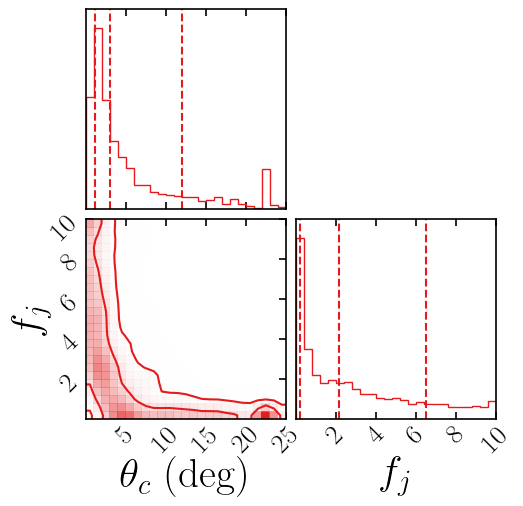

In [56]:
plotter         = TopHatPlotter(
    backend     =   backend,
    output_dir  =   output_dir_eps,
    model_type  =   "theta_c",  # or "flat_theta", "lognormal_theta"
    burn_in     =   5000,
    thin        =   15
)

plotter.plot_corner_last_two()

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import binned_statistic


# 1. Get samples from the backend
# discard burn-in and thin as needed
samples = backend.get_chain(discard=5_000, thin=15, flat=True)
theta_c_samples = samples[:, 4]  # Index 4 is theta_c_deg
fj_samples      = samples[:, 5]  # Index 5 is f_j

# 2. Define Log Bins for theta_c
bin_count = 40
# Ensure we don't take log of <= 0 (though theta_c should be > 0)
min_val = max(np.min(theta_c_samples), 0.1) 
max_val = np.max(theta_c_samples)
theta_bins = np.logspace(np.log10(min_val), np.log10(max_val), bin_count + 1)

# 3. Calculate the median f_j in each log bin
bin_medians, bin_edges, _ = binned_statistic(
    theta_c_samples, fj_samples, statistic='median', bins=theta_bins
)
# Geometric center for log bins (better visual representation in log plot)
bin_centers = np.sqrt(bin_edges[1:] * bin_edges[:-1])

# 4. Find theta* (where median f_j = 1)
valid_mask = ~np.isnan(bin_medians)
# Interpolate: given f_j, find theta_c
interpolator = interp1d(bin_medians[valid_mask], bin_centers[valid_mask], bounds_error=False, fill_value="extrapolate")
theta_star = interpolator(1.0)

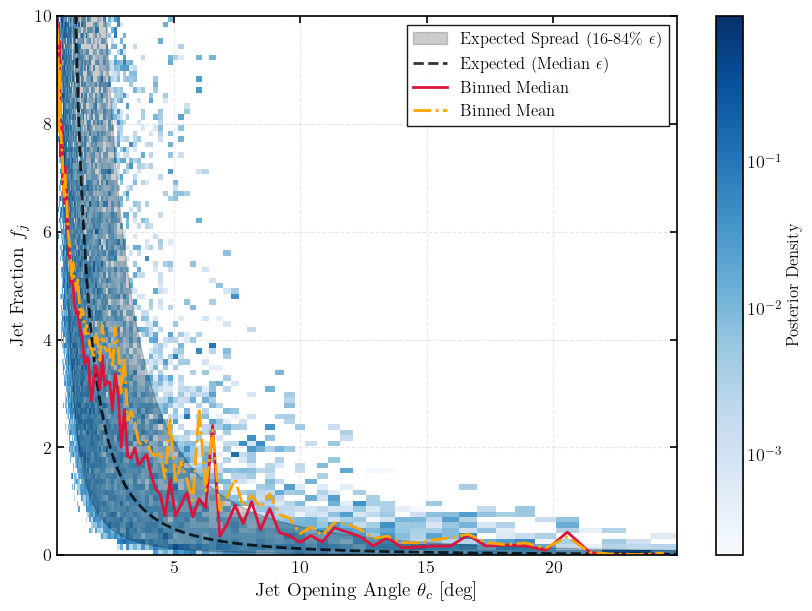

In [29]:

# 1. Prepare Data
x_vals = theta_c_samples
y_vals = fj_samples

# Calculate epsilon statistics for the spread
theta_c_rad     = np.radians(theta_c_samples)
geom_factor     = 1 - np.cos(theta_c_rad)
epsilon_samples = fj_samples * geom_factor

eps_median = np.median(epsilon_samples)
eps_16 = np.percentile(epsilon_samples, 16)
eps_84 = np.percentile(epsilon_samples, 84)

# 2. Define Bins
N_bins = 100
log_bins_x = np.logspace(np.log10(x_vals.min()), np.log10(x_vals.max()), N_bins)
lin_bins_y = np.linspace(y_vals.min(), y_vals.max(), N_bins)

# 3. Calculate Statistics
bin_centers_x = np.sqrt(log_bins_x[1:] * log_bins_x[:-1]) 

bin_medians, _, _ = binned_statistic(x_vals, y_vals, statistic='median', bins=log_bins_x)
bin_means, _, _   = binned_statistic(x_vals, y_vals, statistic='mean', bins=log_bins_x)

# Mode (Best Fit) per bin
counts, _, _ = np.histogram2d(x_vals, y_vals, bins=[log_bins_x, lin_bins_y])
y_centers = 0.5 * (lin_bins_y[1:] + lin_bins_y[:-1]) 
max_y_indices = np.argmax(counts, axis=1) 
bin_modes = y_centers[max_y_indices]
valid_mask = np.sum(counts, axis=1) > 10 

# 4. Plotting
fig, ax = plt.subplots(figsize=(10, 7))

# 2D Histogram
h = ax.hist2d(x_vals, y_vals, bins=[log_bins_x, lin_bins_y], cmap='Blues', density=True, 
              norm=mcolors.LogNorm(), cmin=1e-5)
cbar = plt.colorbar(h[3], ax=ax)
cbar.set_label('Posterior Density', fontsize=12)

# Theoretical Curve & Spread
x_line      = np.logspace(np.log10(x_vals.min()), np.log10(x_vals.max()), 100)
x_line_rad  = np.radians(x_line)
denom       = 1 - np.cos(x_line_rad)

y_line_med  = eps_median / denom
y_line_16   = eps_16 / denom
y_line_84   = eps_84 / denom

# Plot Spread
ax.fill_between(x_line, y_line_16, y_line_84, color='black', alpha=0.2,
                label=r'Expected Spread (16-84\% $\epsilon$)')
ax.plot(x_line, y_line_med, color='black', linestyle='--', linewidth=2, alpha=0.8,
        label=r'Expected (Median $\epsilon$)')

# Plot Binned Statistics
ax.plot(bin_centers_x, bin_medians, color='crimson', linestyle='-', linewidth=2, 
        label='Binned Median')
ax.plot(bin_centers_x, bin_means, color='orange', linestyle='-.', linewidth=2, 
        label='Binned Mean')

# Formatting
#ax.set_xscale('log')
ax.set_yscale('linear')
ax.set_xlabel(r'Jet Opening Angle $\theta_c$ [deg]', fontsize=14)
ax.set_ylabel(r'Jet Fraction $f_j$', fontsize=14)
#ax.set_title(r'Degeneracy Check: Log $\theta_c$ vs Linear $f_j$', fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, which="both", ls="--", alpha=0.3)
ax.set_ylim(0, 10) 
plt.savefig(output_dir_eps / "fj_vs_thetac_with_spread.pdf", dpi=300)

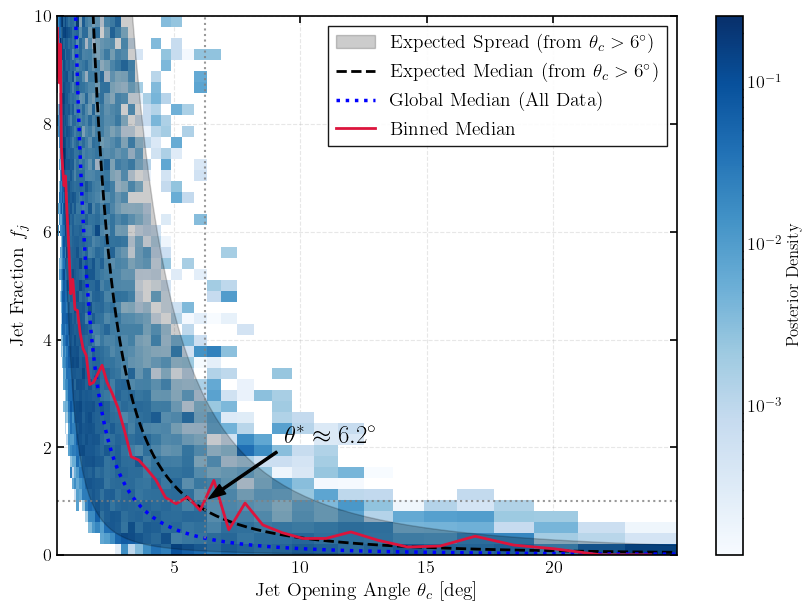

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import binned_statistic

# 1. Prepare Data
x_vals = theta_c_samples
y_vals = fj_samples

# Calculate epsilon
theta_c_rad = np.radians(theta_c_samples)
geom_factor = 1 - np.cos(theta_c_rad)
epsilon_samples = fj_samples * geom_factor

# --- NEW: Select epsilon from theta_c > 6 ---
mask_high = theta_c_samples > 6.0
eps_samples_high = epsilon_samples[mask_high]

# Calculate stats from the restricted (unbiased) population
eps_med_high = np.median(eps_samples_high)
eps_16_high = np.percentile(eps_samples_high, 16)
eps_84_high = np.percentile(eps_samples_high, 84)

# Calculate global median for comparison
eps_med_global = np.median(epsilon_samples)
# --------------------------------------------

# 2. Define Bins
log_bins_x = np.logspace(np.log10(x_vals.min()), np.log10(x_vals.max()), 50)
lin_bins_y = np.linspace(y_vals.min(), y_vals.max(), 50)

# 3. Calculate Statistics (Binned Mode/Median/Mean of actual data)
bin_centers_x = np.sqrt(log_bins_x[1:] * log_bins_x[:-1]) 
bin_medians, _, _ = binned_statistic(x_vals, y_vals, statistic='median', bins=log_bins_x)
bin_means, _, _   = binned_statistic(x_vals, y_vals, statistic='mean', bins=log_bins_x)

counts, _, _ = np.histogram2d(x_vals, y_vals, bins=[log_bins_x, lin_bins_y])
y_centers = 0.5 * (lin_bins_y[1:] + lin_bins_y[:-1]) 
max_y_indices = np.argmax(counts, axis=1) 
bin_modes = y_centers[max_y_indices]
valid_mask = np.sum(counts, axis=1) > 10 

# 4. Plotting
fig, ax = plt.subplots(figsize=(10, 7))

# 2D Histogram
h = ax.hist2d(x_vals, y_vals, bins=[log_bins_x, lin_bins_y], cmap='Blues', density=True, 
              norm=mcolors.LogNorm(), cmin=1e-5)
cbar = plt.colorbar(h[3], ax=ax)
cbar.set_label('Posterior Density', fontsize=12)

# Theoretical Curves
x_line = np.logspace(np.log10(x_vals.min()), np.log10(x_vals.max()), 100)
x_line_rad = np.radians(x_line)
denom = 1 - np.cos(x_line_rad)

y_line_med_high = eps_med_high / denom
y_line_16_high = eps_16_high / denom
y_line_84_high = eps_84_high / denom
y_line_med_global = eps_med_global / denom

# Plot Spread (from theta > 6)
ax.fill_between(x_line, y_line_16_high, y_line_84_high, color='black', alpha=0.2,
                label=r'Expected Spread (from $\theta_c > 6^\circ$)')

# Plot Medians
ax.plot(x_line, y_line_med_high, color='black', linestyle='--', linewidth=2, 
        label=r'Expected Median (from $\theta_c > 6^\circ$)')
ax.plot(x_line, y_line_med_global, color='blue', linestyle=':', linewidth=2.5, 
        label=r'Global Median (All Data)')

# Plot Binned Statistics
ax.plot(bin_centers_x, bin_medians, color='crimson', linestyle='-', linewidth=2, 
        label='Binned Median')

ax.axhline(1, color='gray', linestyle=':', alpha=0.8)
ax.axvline(theta_star, color='gray', linestyle=':', alpha=0.8)

ax.annotate(
    r'$\theta^* \approx {:.1f}^\circ$'.format(theta_star), 
    xy=(theta_star, 1), 
    xytext=(theta_star * 1.5, 2), # Shift text slightly in log space
    arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
    fontsize=18,
    verticalalignment='bottom'
)

# Formatting
#ax.set_xscale('log')
ax.set_yscale('linear')
ax.set_xlabel(r'Jet Opening Angle $\theta_c$ [deg]', fontsize=14)
ax.set_ylabel(r'Jet Fraction $f_j$', fontsize=14)
ax.legend(fontsize=14, loc='upper right')
ax.grid(True, which="both", ls="--", alpha=0.3)
ax.set_ylim(0, 10) 

plt.savefig(output_dir_eps / "epsilon_degeneracy_check_unbiased.pdf", dpi=300)

Saved plot to Output_files/Epsilon_test_flat_theta/degeneracy_concept_plot.pdf


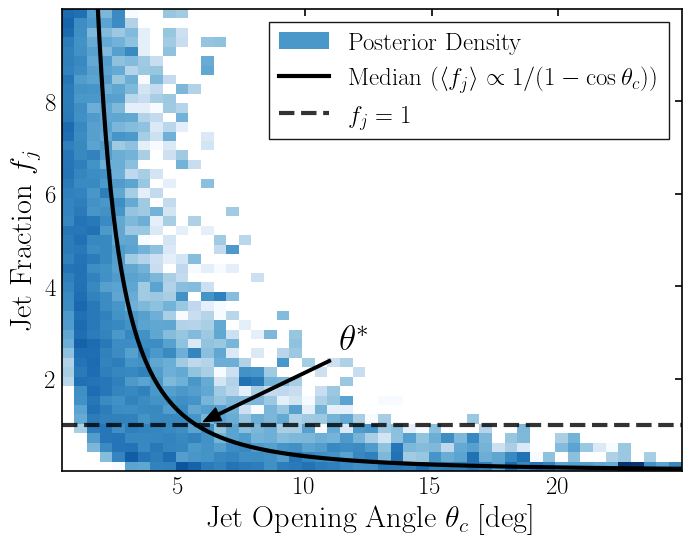

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# 1. Prepare Data
x_vals = theta_c_samples
y_vals = fj_samples

# Calculate unbiased epsilon (representing the true physics)
theta_c_rad = np.radians(theta_c_samples)
geom_factor = 1 - np.cos(theta_c_rad)
epsilon_samples = fj_samples * geom_factor

mask_high = theta_c_samples > 6.0
eps_med_unbiased = np.median(epsilon_samples[mask_high])
theta_star_rad = np.arccos(1 - eps_med_unbiased)
theta_star = np.degrees(theta_star_rad)

# 2. Plotting
fig, ax = plt.subplots(figsize=(8, 6))

# 2D Histogram (Background)
log_bins_x = np.logspace(np.log10(x_vals.min()), np.log10(x_vals.max()), 50)
lin_bins_x = np.linspace(x_vals.min(), x_vals.max(), 50)
lin_bins_y = np.linspace(y_vals.min(), y_vals.max(), 50)

h = ax.hist2d(x_vals, y_vals, bins=[lin_bins_x, lin_bins_y], cmap='Blues', density=True, 
              norm=mcolors.LogNorm(), cmin=1e-5)

x_line = np.logspace(np.log10(x_vals.min()), np.log10(x_vals.max()), 100)
x_line_rad = np.radians(x_line)
y_line = eps_med_unbiased / (1 - np.cos(x_line_rad))

line, = ax.plot(x_line, y_line, color='black', linestyle='-', linewidth=3, 
        label=r'Median ($\left<f_j \right> \propto 1/(1 - \cos\theta_c$))')

# Theta* Annotation (Concept only)
line2 = ax.axhline(1, color='k', linestyle='--', alpha=0.8, linewidth=3, label=r'$f_j = 1$')
 
ax.annotate(
    r'$\theta^*$', 
    xy=(theta_star, 1), 
    xytext=(theta_star * 2, 2.5), 
    arrowprops=dict(facecolor='black', shrink=0.05, width=1.8, headwidth=10),
    fontsize=26,
    #bold
    fontweight='bold',
    verticalalignment='bottom'
)
from matplotlib.patches import Patch

# --- NEW: Custom Legend ---
legend_elements = [
    Patch(facecolor=plt.cm.Blues(0.6), edgecolor='none', label='Posterior Density'),
    line,
    line2
]
ax.legend(handles=legend_elements, fontsize=18, loc='upper right')
# --------------------------
# Formatting
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_xlabel(r'Jet Opening Angle $\theta_c$ [deg]', fontsize=22)
ax.set_ylabel(r'Jet Fraction $f_j$', fontsize=22)
# make ticks larger
ax.tick_params(axis='both', which='major', labelsize=18)
plt.savefig(output_dir_eps / "degeneracy_concept_plot.pdf", dpi=300)
print(f"Saved plot to {output_dir_eps / 'degeneracy_concept_plot.pdf'}")
plt.show()

# Flat Theta

In [84]:
# Cell: Model-specific definitions

from src.top_hat.montecarlo import *

N_PARAMS    = 6
PARAM_NAMES = ["A_index", "L_L0", "L_mu_E", "sigma_E", "theta_c_max", "fj"]

def log_prior_ft(thetas, max_fj = 10):
    A_index, L_L0, L_mu_E, sigma_E, theta_c_max, fj = thetas
    
    if not (1.5 < A_index < 12): return -inf
    if not (-2 < L_L0 < 7): return -inf
    if not (0.1 < L_mu_E < 7): return -inf
    if not (0 < sigma_E < 2.5): return -inf
    if not (1 < theta_c_max < 25): return -inf
    if not (0 < fj < max_fj): return -inf
    
    return 0.0

def log_likelihood_flat_theta(thetas, params_in, distances, k_interpolator, n_events=10_000):
    theta_c_max, fj             = thetas[4], thetas[5]
    gbm_eff                     = 0.6
    geometric_efficiency        = calculate_geometric_efficiency_flat(theta_c_max)
    triggered_years             = params_in.triggered_years
    epsilon                     = geometric_efficiency * fj
    n_years                     = triggered_years
    intrinsic_rate_per_year     = epsilon * len(params_in.z_arr) * gbm_eff
    expected_events             = intrinsic_rate_per_year * n_years
    #n_events                    = int(expected_events)
    
    results                     = simplified_montecarlo(thetas, n_events, params_in, distances, k_interpolator)
    
    trigger_mask, analysis_mask = apply_detection_cuts(results["p_flux"], results["E_p_obs"])
    
    if np.sum(analysis_mask) <= 3:
        return -inf, -inf, -inf, -inf, -inf
    
    
    triggered_events        = np.sum(trigger_mask)
    physics_efficiency      = triggered_events  / n_events

    #simulated_rate_per_year = triggered_events / n_years
    #predicted_detections    = simulated_rate_per_year * params_in.triggered_years
    
    predicted_detections    = expected_events * physics_efficiency
    observed_detections     = params_in.yearly_rate * params_in.triggered_years

    l1 = score_func_cvm(results["p_flux"][analysis_mask], params_in.pflux_data, params_in.rng)
    l2 = score_func_cvm(results["E_p_obs"][analysis_mask], params_in.epeak_data, params_in.rng)
    l3 = poiss_log(k=observed_detections, mu=predicted_detections)

    return l1 + l2 + l3, l1, l2, l3, physics_efficiency

def initialize_walkers_ft(n_walkers):
    np.random.seed(42)
    return np.column_stack([
        np.random.uniform(2, 3, n_walkers),
        np.random.uniform(2, 4.0, n_walkers),
        np.random.uniform(2.0, 4.0, n_walkers),
        np.random.uniform(0.2, 1, n_walkers),
        np.random.uniform(1, 10, n_walkers),    # theta_c_max
        np.random.uniform(0.5, 4, n_walkers),   # fj
    ])

In [58]:
# Where to find the datafiles and save the outputs
output_dir_ft  = src.init.create_run_dir(f"Paper_Results/Flat_Theta/fiducial")

default_params, _, data_dict = src.init.initialize_simulation(datafiles, params=params) #? Catalogue data from fermi GBM

print(f"Total events in the catalogue: {len(default_params.pflux_data)}")

n_walkers       = 20
n_steps         = 60_000

k_interpolator  = create_k_interpolator()
initial_walkers = initialize_walkers_ft(n_walkers)

log_likelihood_default_in_ft = create_log_probability_function(
    log_prior_func          =   log_prior_ft,
    log_likelihood_func     =   log_likelihood_flat_theta,
    params_in               =   default_params,
    k_interpolator          =   k_interpolator
)

filename    = output_dir_ft / "emcee.h5"
initial_pos, n_steps, backend = check_and_resume_mcmc(
    filename                    =   filename, 
    n_steps                     =   n_steps, 
    initialize_walkers_func     =   initialize_walkers_ft, 
    n_walkers                   =   n_walkers
)

sampler = run_mcmc(
    log_probability_func    =   log_likelihood_default_in_ft,
    initial_walkers         =   initial_pos,
    n_iterations            =   n_steps,
    n_walkers               =   n_walkers,
    n_params                =   N_PARAMS,
    backend                 =   backend,
)

Loading existing directory  : Output_files/Paper_Results/Flat_Theta/fiducial
Using redshift model: samples_fiducial_Hrad_A1.0_BNSs_0.dat with 359079 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
Total events in the catalogue: 268
Already completed this run


0it [00:00, ?it/s]


In [86]:
# Make sure we're using the backend from the flat_theta run
backend_ft  = emcee.backends.HDFBackend(output_dir_ft / "emcee.h5")

plotter_flat_theta = TopHatPlotter(
    backend     =   backend_ft,  # Use explicit backend variable
    output_dir  =   output_dir_ft,
    model_type  =   "flat_theta",
    burn_in     =   1000,
    thin        =   15
)   

# Generate all plots
distances = compute_luminosity_distance(default_params.z_arr)
summary = plotter_flat_theta.generate_all_plots(
    mc_func=simplified_montecarlo,
    params_in=default_params,
    distances=distances,
    k_interpolator=k_interpolator,
    geometric_eff_func=calculate_geometric_efficiency_flat
)
print(summary)

Generating corner plot...
(78660, 6)
Generating likelihood evolution...
Generating autocorrelation plot...
Generating corner plot for last two parameters...
Generating CDF comparison...
All plots saved to: Output_files/Paper_Results/Flat_Theta/fiducial
\begin{tabular}{lc}
\hline
Parameter & Value \\
\hline
$k$ & $6.127_{-2.836}^{+3.757}$ \\
$\log_{10}(L_0)$ & $3.153_{-0.480}^{+0.429}$ \\
$\log_{10}(\mu_E)$ & $3.425_{-0.171}^{+0.373}$ \\
$\sigma_E$ & $0.394_{-0.085}^{+0.155}$ \\
$\theta_{c,\max}$ (deg) & $4.197_{-2.365}^{+5.036}$ \\
$f_j$ & $2.827_{-2.156}^{+3.876}$ \\
\hline
\end{tabular}


Mean fj: 2.8314288667354264


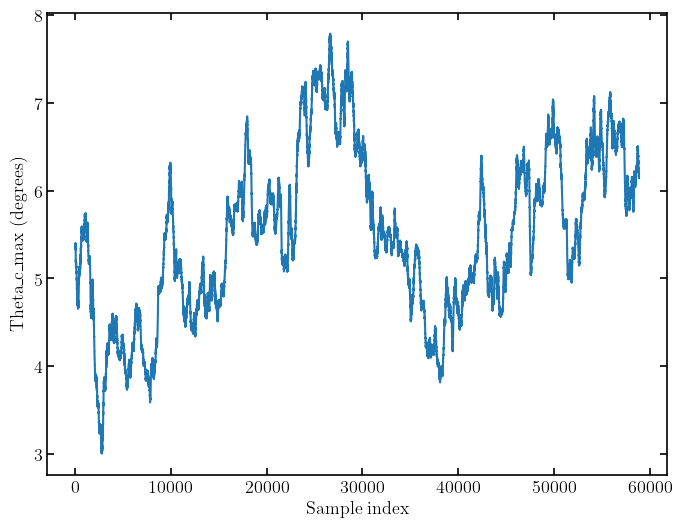

In [60]:
fj = backend_ft.get_chain(discard=1000, thin=20, flat=True)[:,-1]
print(f"Mean fj: {np.median(fj)}")

theta_c_max = backend_ft.get_chain(discard=1000, thin=20, flat=True)[:,-2]

running_mean_theta_c = np.convolve(theta_c_max, np.ones(100)/100, mode='valid')
plt.plot(running_mean_theta_c)
plt.xlabel("Sample index")
plt.ylabel("Theta_c_max (degrees)")
plt.show()

# Log-Normal

In [61]:
# Cell: Model-specific definitions

from src.top_hat.montecarlo import *

N_PARAMS        = 6
PARAM_NAMES     = ["A_index", "L_L0", "L_mu_E", "sigma_E", "theta_c_med_10", "fj"]

def log_prior_log_normal(thetas, max_fj=10):
    A_index, L_L0, L_mu_E, sigma_E, theta_c_med_10, fj = thetas

    if not (1.5 < A_index < 12): return -inf
    if not (-2 < L_L0 < 7): return -inf
    if not (0.1 < L_mu_E < 7): return -inf
    if not (0 < sigma_E < 2.5): return -inf
    if not (np.log10(1) < theta_c_med_10 < np.log10(25)): return -inf
    if not (0 < fj < max_fj): return -inf
    
    return 0.0

geom_eff_interp = create_geometric_efficiency_lognormal_interpolator(sigma_theta_c=0.5)
def log_likelihood_log_normal(thetas, params_in, distances, k_interpolator, n_events=10_000):
    theta_c_med_10, fj          = thetas[4], thetas[5]
    
    gbm_eff                     = 0.6
    geometric_efficiency        = geom_eff_interp(theta_c_med_10)
    triggered_years             = params_in.triggered_years
    epsilon                     = geometric_efficiency * fj

    factor                      = 1 # Simulate less as the effieicny is already making this hella slow
    n_years                     = triggered_years / factor
    intrinsic_rate_per_year     = epsilon * len(params_in.z_arr) * gbm_eff
    expected_events             = intrinsic_rate_per_year * n_years
    #n_events                    = int(expected_events)
    
    #if n_events < 50/factor:  # We have 300 events in the data, so even with perfect detection we need at least this many
    #    return -inf, -inf, -inf, -inf, -inf
    
    results                     = simplified_montecarlo(thetas, n_events, params_in, distances, k_interpolator)
    
    trigger_mask, analysis_mask = apply_detection_cuts(results["p_flux"], results["E_p_obs"])
    
    if np.sum(analysis_mask) <= 3:
        return -inf, -inf, -inf, -inf, -inf
    
    triggered_events        = np.sum(trigger_mask)
    physics_efficiency      = triggered_events  / n_events

    #simulated_rate_per_year = triggered_events / n_years
    #predicted_detections    = simulated_rate_per_year * params_in.triggered_years
    
    predicted_detections    = expected_events * physics_efficiency
    observed_detections     = params_in.yearly_rate * params_in.triggered_years
    
    l1 = score_func_cvm(results["p_flux"][analysis_mask], params_in.pflux_data, params_in.rng)
    l2 = score_func_cvm(results["E_p_obs"][analysis_mask], params_in.epeak_data, params_in.rng)
    l3 = poiss_log(k=observed_detections, mu=predicted_detections)
        
    return l1 + l2 + l3, l1, l2, l3, physics_efficiency

# log_likelihood similar to flat case but uses calculate_geometric_efficiency_lognormal

def initialize_walkers_log_normal(n_walkers):
    np.random.seed(42)
    return np.column_stack([
        np.random.uniform(2, 3, n_walkers),
        np.random.uniform(2, 4.0, n_walkers),
        np.random.uniform(2.0, 4.0, n_walkers),
        np.random.uniform(0.2, 1, n_walkers),
        np.random.uniform(np.log10(5), np.log10(10), n_walkers),  
        np.random.uniform(0.5, 1, n_walkers),
    ])

KeyboardInterrupt: 

In [ ]:
output_dir_lm                       = src.init.create_run_dir(f"Paper_Results/Lognormal_Theta/fiducial")

Loading existing directory  : Output_files/Paper_Results/Lognormal_Theta/fiducial


In [ ]:
# Where to find the datafiles and save the outputs

default_params, _, data_dict        = src.init.initialize_simulation(datafiles, params=params) #? Catalogue data from fermi GBM

print(f"Total events in the catalogue: {len(default_params.pflux_data)}")

n_walkers       = 20
n_steps         = 90_000

k_interpolator  = create_k_interpolator()

log_likelihood_default_in_log_normal = create_log_probability_function(
    log_prior_func          =   log_prior_log_normal,
    log_likelihood_func     =   log_likelihood_log_normal,
    params_in               =   default_params,
    k_interpolator          =   k_interpolator
)

initial_pos, n_steps, backend = check_and_resume_mcmc(
    filename                    =    output_dir_lm / "emcee.h5", 
    n_steps                     =   n_steps, 
    initialize_walkers_func     =   initialize_walkers_log_normal, 
    n_walkers                   =   n_walkers
)

sampler = run_mcmc(
    log_probability_func    =   log_likelihood_default_in_log_normal,
    initial_walkers         =   initial_pos,
    n_iterations            =   n_steps,
    n_walkers               =   n_walkers,
    n_params                =   N_PARAMS,
    backend                 =   backend,
)

Using redshift model: samples_fiducial_Hrad_A1.0_BNSs_0.dat with 359079 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
Total events in the catalogue: 268
Already completed this run


0it [00:00, ?it/s]


In [ ]:
# plot
backend_ln = emcee.backends.HDFBackend(output_dir_lm / "emcee.h5")

plotter_log_normal = TopHatPlotter(
    backend     =   backend_ln,
    output_dir  =   output_dir_lm,
    model_type  =   "lognormal_theta",
    burn_in     =   3_000,
    thin        =   15
)

# Generate all plots
distances = compute_luminosity_distance(default_params.z_arr)
summary = plotter_log_normal.generate_all_plots(
    mc_func=simplified_montecarlo,
    params_in=default_params,
    distances=distances,
    k_interpolator=k_interpolator,
    geometric_eff_func=geom_eff_interp
)

print(summary)  # Print LaTeX table

Generating corner plot...
(116000, 6)
Generating likelihood evolution...
Generating autocorrelation plot...
Generating corner plot for last two parameters...
Generating CDF comparison...
All plots saved to: Output_files/Paper_Results/Lognormal_Theta/fiducial
\begin{tabular}{lc}
\hline
Parameter & Value \\
\hline
$k$ & $6.483_{-3.101}^{+3.772}$ \\
$\log_{10}(L_0)$ & $2.947_{-0.484}^{+0.517}$ \\
$\log_{10}(\mu_E)$ & $3.472_{-0.207}^{+0.646}$ \\
$\sigma_E$ & $0.420_{-0.100}^{+0.231}$ \\
$\log_{10}(\theta_{c,\mathrm{med}})$ & $0.259_{-0.200}^{+0.311}$ \\
$f_j$ & $0.650_{-0.529}^{+1.825}$ \\
\hline
\end{tabular}


In [20]:
theta_c_med_10_samples = backend_ln.get_chain(discard=1000, thin=20, flat=True)[:,-2]
print(f"Mean theta_c: {(10**np.median(theta_c_med_10_samples))} degrees")

Mean theta_c: 1.8277149663694712 degrees


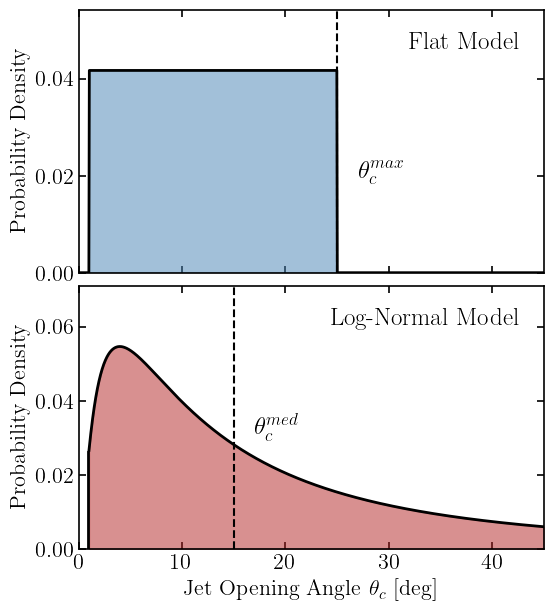

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm

# --- Parameters ---
# Use the best-fit values calculated previously
# If running this cell standalone, replace these with specific values (e.g., 10.0 and 5.0)
val_flat_max = 25  # Parameter theta_c_max for Flat model
val_log_med  = 15  # Parameter theta_c_med for Log-Normal model
sigma_log10  = 0.5
s = sigma_log10 * np.log(10)

# --- Setup Plot ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 7), sharex=True)
plt.subplots_adjust(hspace=0.05) # Adjust space between plots

# ==========================================
# 1. Flat Distribution (Top Panel)
# ==========================================
# Defined on [1, theta_max]
x_flat = np.linspace(0, 90, 2000)
pdf_flat = np.zeros_like(x_flat)

# Calculate height to normalize area to 1 over [1, theta_max]
if val_flat_max > 1:
    height = 1.0 / (val_flat_max - 1.0)
    mask_flat = (x_flat >= 1) & (x_flat <= val_flat_max)
    pdf_flat[mask_flat] = height

# Plot
ax1.plot(x_flat, pdf_flat, 'k-', lw=2)
ax1.fill_between(x_flat, 0, pdf_flat, color='steelblue', alpha=0.5)

# Annotation
ax1.axvline(val_flat_max, color='k', linestyle='--', lw=1.5)
ax1.text(val_flat_max + 2, height/2, r'$\theta_{c}^{max}$', fontsize=18, va='center')

# Formatting
ax1.set_ylabel(r'Probability Density', fontsize=16)
ax1.text(0.95, 0.85, 'Flat Model', transform=ax1.transAxes, ha='right', fontsize=18, weight='bold')
ax1.set_ylim(0, height * 1.3)

# ==========================================
# 2. Log-Normal Distribution (Bottom Panel)
# ==========================================
# Defined on [1, 90]
scale = val_log_med # Scale is the Median

# Calculate Normalization for truncation [1, 45]
cdf_45 = lognorm.cdf(45, s=s, scale=scale)
cdf_1  = lognorm.cdf(1, s=s, scale=scale)
norm   = cdf_45 - cdf_1

# Calculate PDF
x_ln = np.linspace(1, 45, 2000)
pdf_ln_raw = lognorm.pdf(x_ln, s=s, scale=scale)
pdf_ln = pdf_ln_raw / norm

# Plot
ax2.plot(x_ln, pdf_ln, 'k-', lw=2)
ax2.fill_between(x_ln, 0, pdf_ln, color='firebrick', alpha=0.5)
# black line at x = 1 to show lower limit up till the value of the pdf at x=1
ax2.plot([0.952, 0.952], [0, pdf_ln[0]*0.98], 'k-', lw=2)

# Annotation for Median
ax2.axvline(val_log_med, color='k', linestyle='--', lw=1.5)
ax2.text(val_log_med + 2, np.max(pdf_ln)/2 + 0.1 * np.max(pdf_ln), r'$\theta_{c}^{med}$', fontsize=18, va='center')

# Formatting
ax2.set_ylabel(r'Probability Density', fontsize=16)
ax2.set_xlabel(r'Jet Opening Angle $\theta_c$ [deg]', fontsize=16)
ax2.text(0.95, 0.85, 'Log-Normal Model', transform=ax2.transAxes, ha='right', fontsize=18, weight='bold')
ax2.set_xlim(0, 45)
ax2.set_ylim(0, np.max(pdf_ln) * 1.3)
#make ticks larger

ax1.tick_params(axis='both', which='major', labelsize=16)   
ax2.tick_params(axis='both', which='major', labelsize=16)

# Save
plt.savefig(output_dir_eps / "paper_model_distributions.pdf", bbox_inches='tight', dpi=300)
plt.show()

In [25]:
output_dir_eps

PosixPath('Output_files/Epsilon_test_flat_theta')

In [166]:
1/0

ZeroDivisionError: division by zero

# Multiple Populations

In [26]:
from multiprocessing import Pool
from pathlib import Path
import src.init
from src.spectral_models import DEFAULT_SPECTRAL_PARAMS
population_folder = Path("datafiles") / "populations" / "samples"
#with glob find all the samples_*.dat files
samples         = list(population_folder.glob('samples_*.dat'))
samp_names      = [samp.name.split('samples_')[1].split('_BNSs')[0] for samp in samples]
print(f"Found {len(samples)} samples: {samp_names}")
total_num_samp  = len(samp_names)
datafiles       = Path("datafiles")

Found 64 samples: ['fiducial_delayed_A0.5', 'fiducial_delayed_A1.0', 'fiducial_delayed_A3.0', 'fiducial_delayed_A5.0', 'fiducial_fmtbse_A0.5', 'fiducial_fmtbse_A1.0', 'fiducial_fmtbse_A3.0', 'fiducial_fmtbse_A5.0', 'fiducial_HGoptimistic_A0.5', 'fiducial_HGoptimistic_A1.0', 'fiducial_HGoptimistic_A3.0', 'fiducial_HGoptimistic_A5.0', 'fiducial_Hrad_5M_A0.5', 'fiducial_Hrad_5M_A1.0', 'fiducial_Hrad_5M_A3.0', 'fiducial_Hrad_5M_A5.0', 'fiducial_Hrad_A0.5', 'fiducial_Hrad_A1.0', 'fiducial_Hrad_A3.0', 'fiducial_Hrad_A5.0', 'fiducial_kick150_A0.5', 'fiducial_kick150_A1.0', 'fiducial_kick150_A3.0', 'fiducial_kick150_A5.0', 'fiducial_kick265_A0.5', 'fiducial_kick265_A1.0', 'fiducial_kick265_A3.0', 'fiducial_kick265_A5.0', 'fiducial_klencki_A0.5', 'fiducial_klencki_A1.0', 'fiducial_klencki_A3.0', 'fiducial_klencki_A5.0', 'fiducial_l01_A0.5', 'fiducial_l01_A1.0', 'fiducial_l01_A3.0', 'fiducial_l01_A5.0', 'fiducial_notides_A0.5', 'fiducial_notides_A1.0', 'fiducial_notides_A3.0', 'fiducial_notides_

In [27]:
n_steps = 14_000

for z_test in samp_names:
    print(f"Processing population: {z_test} ({samp_names.index(z_test)+1}/{total_num_samp})")
    
    # --- Common Setup for this population ---
    params_pop = DEFAULT_SPECTRAL_PARAMS.copy()
    params_pop["z_model"] = z_test

    # Initialize simulation with specific population
    current_params, _, _ = src.init.initialize_simulation(datafiles, params_pop)
    
    # Pre-compute distances and interpolator
    k_interpolator = create_k_interpolator()

    # ==========================================
    # Model 1: Theta_c (Direct sampling) - 6 Parameters
    # ==========================================
    print(f"  >> Running Theta_c model for {z_test}...")
    output_dir_theta_c = src.init.create_run_dir(f"ProductionPop_Theta_c_10k/{z_test}", use_timestamp=False)
    filename_theta_c = output_dir_theta_c / "emcee.h5"
    
    # Create log prob function for Theta_c model
    log_prob_theta_c = create_log_probability_function(
        log_prior_func      = log_prior,                    # Uses theta_c + f_j
        log_likelihood_func = log_likelihood_default,       # Uses theta_c + f_j
        params_in           = current_params,
        k_interpolator      = k_interpolator
    )
    
    # Check resume status
    initial_pos_theta_c, steps_todo_theta_c, backend_theta_c = check_and_resume_mcmc(
        filename                = filename_theta_c,
        n_steps                 = n_steps,
        initialize_walkers_func = initialize_walkers,       # Returns 6 params
        n_walkers               = n_walkers
    )
    
    # Run if needed 
    if steps_todo_theta_c > 0:
        run_mcmc(
            log_probability_func = log_prob_theta_c,
            initial_walkers      = initial_pos_theta_c,
            n_iterations         = steps_todo_theta_c,
            n_walkers            = n_walkers, 
            n_params             = 6,                        # ← CHANGED FROM 5 TO 6
            backend              = backend_theta_c,      
        )
    else:
        print("     Theta_c model already completed.")

Processing population: fiducial_delayed_A0.5 (1/64)
Using redshift model: samples_fiducial_delayed_A0.5_BNSs_0.dat with 60187 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Theta_c model for fiducial_delayed_A0.5...
Loading existing directory  : Output_files/ProductionPop_Theta_c_10k/fiducial_delayed_A0.5
Already completed this run
     Theta_c model already completed.
Processing population: fiducial_delayed_A1.0 (2/64)
Using redshift model: samples_fiducial_delayed_A1.0_BNSs_0.dat with 342071 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Theta_c model for fiducial_d

100%|██████████| 1259/1259 [01:44<00:00, 12.05it/s]


Processing population: fiducial_notides_pericirc_A5.0 (44/64)
Using redshift model: samples_fiducial_notides_pericirc_A5.0_BNSs_0.dat with 241080 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Theta_c model for fiducial_notides_pericirc_A5.0...
Loading existing directory  : Output_files/ProductionPop_Theta_c_10k/fiducial_notides_pericirc_A5.0
Continuing from iteration 10000


100%|██████████| 4000/4000 [05:44<00:00, 11.60it/s]


Processing population: fiducial_pisnfarmer19_A0.5 (45/64)
Using redshift model: samples_fiducial_pisnfarmer19_A0.5_BNSs_0.dat with 62278 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Theta_c model for fiducial_pisnfarmer19_A0.5...
Loading existing directory  : Output_files/ProductionPop_Theta_c_10k/fiducial_pisnfarmer19_A0.5
Continuing from iteration 10000


100%|██████████| 4000/4000 [05:24<00:00, 12.34it/s]


Processing population: fiducial_pisnfarmer19_A1.0 (46/64)
Using redshift model: samples_fiducial_pisnfarmer19_A1.0_BNSs_0.dat with 359079 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Theta_c model for fiducial_pisnfarmer19_A1.0...
Loading existing directory  : Output_files/ProductionPop_Theta_c_10k/fiducial_pisnfarmer19_A1.0
Continuing from iteration 10000


100%|██████████| 4000/4000 [05:33<00:00, 12.01it/s]


Processing population: fiducial_pisnfarmer19_A3.0 (47/64)
Using redshift model: samples_fiducial_pisnfarmer19_A3.0_BNSs_0.dat with 368417 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Theta_c model for fiducial_pisnfarmer19_A3.0...
Loading existing directory  : Output_files/ProductionPop_Theta_c_10k/fiducial_pisnfarmer19_A3.0
Continuing from iteration 10000


100%|██████████| 4000/4000 [05:24<00:00, 12.32it/s]


Processing population: fiducial_pisnfarmer19_A5.0 (48/64)
Using redshift model: samples_fiducial_pisnfarmer19_A5.0_BNSs_0.dat with 139399 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Theta_c model for fiducial_pisnfarmer19_A5.0...
Loading existing directory  : Output_files/ProductionPop_Theta_c_10k/fiducial_pisnfarmer19_A5.0
Continuing from iteration 10000


100%|██████████| 4000/4000 [05:31<00:00, 12.08it/s]


Processing population: fiducial_qcbse_A0.5 (49/64)
Using redshift model: samples_fiducial_qcbse_A0.5_BNSs_0.dat with 7215 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Theta_c model for fiducial_qcbse_A0.5...
Loading existing directory  : Output_files/ProductionPop_Theta_c_10k/fiducial_qcbse_A0.5
Continuing from iteration 10000


100%|██████████| 4000/4000 [05:21<00:00, 12.45it/s]


Processing population: fiducial_qcbse_A1.0 (50/64)
Using redshift model: samples_fiducial_qcbse_A1.0_BNSs_0.dat with 50948 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Theta_c model for fiducial_qcbse_A1.0...
Loading existing directory  : Output_files/ProductionPop_Theta_c_10k/fiducial_qcbse_A1.0
Continuing from iteration 10000


100%|██████████| 4000/4000 [05:06<00:00, 13.05it/s]


Processing population: fiducial_qcbse_A3.0 (51/64)
Using redshift model: samples_fiducial_qcbse_A3.0_BNSs_0.dat with 26323 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Theta_c model for fiducial_qcbse_A3.0...
Loading existing directory  : Output_files/ProductionPop_Theta_c_10k/fiducial_qcbse_A3.0
Continuing from iteration 10000


100%|██████████| 4000/4000 [05:05<00:00, 13.09it/s]


Processing population: fiducial_qcbse_A5.0 (52/64)
Using redshift model: samples_fiducial_qcbse_A5.0_BNSs_0.dat with 21188 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Theta_c model for fiducial_qcbse_A5.0...
Loading existing directory  : Output_files/ProductionPop_Theta_c_10k/fiducial_qcbse_A5.0
Continuing from iteration 10000


100%|██████████| 4000/4000 [04:53<00:00, 13.61it/s]


Processing population: fiducial_qhe_A0.5 (53/64)
Using redshift model: samples_fiducial_qhe_A0.5_BNSs_0.dat with 60765 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Theta_c model for fiducial_qhe_A0.5...
Loading existing directory  : Output_files/ProductionPop_Theta_c_10k/fiducial_qhe_A0.5
Continuing from iteration 10000


100%|██████████| 4000/4000 [05:01<00:00, 13.28it/s]


Processing population: fiducial_qhe_A1.0 (54/64)
Using redshift model: samples_fiducial_qhe_A1.0_BNSs_0.dat with 352810 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Theta_c model for fiducial_qhe_A1.0...
Loading existing directory  : Output_files/ProductionPop_Theta_c_10k/fiducial_qhe_A1.0
Continuing from iteration 10000


100%|██████████| 4000/4000 [06:04<00:00, 10.97it/s]


Processing population: fiducial_qhe_A3.0 (55/64)
Using redshift model: samples_fiducial_qhe_A3.0_BNSs_0.dat with 358765 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Theta_c model for fiducial_qhe_A3.0...
Loading existing directory  : Output_files/ProductionPop_Theta_c_10k/fiducial_qhe_A3.0
Continuing from iteration 10000


100%|██████████| 4000/4000 [05:44<00:00, 11.60it/s]


Processing population: fiducial_qhe_A5.0 (56/64)
Using redshift model: samples_fiducial_qhe_A5.0_BNSs_0.dat with 125569 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Theta_c model for fiducial_qhe_A5.0...
Loading existing directory  : Output_files/ProductionPop_Theta_c_10k/fiducial_qhe_A5.0
Continuing from iteration 10000


100%|██████████| 4000/4000 [05:39<00:00, 11.80it/s]


Processing population: fiducial_rad_A0.5 (57/64)
Using redshift model: samples_fiducial_rad_A0.5_BNSs_0.dat with 180620 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Theta_c model for fiducial_rad_A0.5...
Loading existing directory  : Output_files/ProductionPop_Theta_c_10k/fiducial_rad_A0.5
Continuing from iteration 10000


100%|██████████| 4000/4000 [05:35<00:00, 11.93it/s]


Processing population: fiducial_rad_A1.0 (58/64)
Using redshift model: samples_fiducial_rad_A1.0_BNSs_0.dat with 100757 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Theta_c model for fiducial_rad_A1.0...
Loading existing directory  : Output_files/ProductionPop_Theta_c_10k/fiducial_rad_A1.0
Continuing from iteration 10000


100%|██████████| 4000/4000 [05:38<00:00, 11.82it/s]


Processing population: fiducial_rad_A3.0 (59/64)
Using redshift model: samples_fiducial_rad_A3.0_BNSs_0.dat with 50479 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Theta_c model for fiducial_rad_A3.0...
Loading existing directory  : Output_files/ProductionPop_Theta_c_10k/fiducial_rad_A3.0
Continuing from iteration 10000


100%|██████████| 4000/4000 [05:24<00:00, 12.32it/s]


Processing population: fiducial_rad_A5.0 (60/64)
Using redshift model: samples_fiducial_rad_A5.0_BNSs_0.dat with 44357 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Theta_c model for fiducial_rad_A5.0...
Loading existing directory  : Output_files/ProductionPop_Theta_c_10k/fiducial_rad_A5.0
Continuing from iteration 10000


100%|██████████| 4000/4000 [05:09<00:00, 12.91it/s]


Processing population: fiducial_xuli_A0.5 (61/64)
Using redshift model: samples_fiducial_xuli_A0.5_BNSs_0.dat with 2130 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Theta_c model for fiducial_xuli_A0.5...
Loading existing directory  : Output_files/ProductionPop_Theta_c_10k/fiducial_xuli_A0.5
Continuing from iteration 10000


100%|██████████| 4000/4000 [05:04<00:00, 13.12it/s]


Processing population: fiducial_xuli_A1.0 (62/64)
Using redshift model: samples_fiducial_xuli_A1.0_BNSs_0.dat with 45515 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Theta_c model for fiducial_xuli_A1.0...
Loading existing directory  : Output_files/ProductionPop_Theta_c_10k/fiducial_xuli_A1.0
Continuing from iteration 10000


100%|██████████| 4000/4000 [04:57<00:00, 13.43it/s]


Processing population: fiducial_xuli_A3.0 (63/64)
Using redshift model: samples_fiducial_xuli_A3.0_BNSs_0.dat with 276961 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Theta_c model for fiducial_xuli_A3.0...
Loading existing directory  : Output_files/ProductionPop_Theta_c_10k/fiducial_xuli_A3.0
Continuing from iteration 10000


100%|██████████| 4000/4000 [05:00<00:00, 13.30it/s]


Processing population: fiducial_xuli_A5.0 (64/64)
Using redshift model: samples_fiducial_xuli_A5.0_BNSs_0.dat with 409987 BNSs.
Generating temporal interpolators... (this may take a moment)
Preparing catalogue with limits: {'F_LIM': 4, 'T90_LIM': 2, 'EP_LIM_UPPER': 10000, 'EP_LIM_LOWER': 50}
Triggered events: 310, Trigger years: 16.66, Yearly rate: 18.61 events/year
  >> Running Theta_c model for fiducial_xuli_A5.0...
Loading existing directory  : Output_files/ProductionPop_Theta_c_10k/fiducial_xuli_A5.0
Continuing from iteration 10000


100%|██████████| 4000/4000 [05:12<00:00, 12.81it/s]


In [ ]:
1/0

ZeroDivisionError: division by zero

In [79]:
%load_ext autoreload
%autoreload 2

from src.plots_oop_epsilon import EpsilonModelPlotter, FjModelPlotter, ThetaCModelPlotter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
# For Theta_c models (6 parameters)
run_name = "ProductionPop_Theta_c_10k"
BASE_DIR_THETA_C = Path(run_name)
OUTPUT_DIR_THETA_C = Path("Output_files") / run_name
OUTPUT_DIR_THETA_C.mkdir(parents=True, exist_ok=True)
DATA_FILES_DIR  = datafiles
SAMP_NAMES      = samp_names

plotter_theta_c = ThetaCModelPlotter(
    samp_names=SAMP_NAMES,
    base_dir=str(BASE_DIR_THETA_C),
    data_files_dir=str(DATA_FILES_DIR),
    output_dir  =str(OUTPUT_DIR_THETA_C),
    discard     =1000,
    thin        =20,
    k_params    =6,
    theta_c_idx =4,  # Index of theta_c in degrees
    fj_idx      =5,       # Index of fj in parameter array
)

# Generate all plots
#plotter_theta_c.plot_violins_fj(filename="fj_violin_plot.pdf", max_fj=10)
#plotter_theta_c.plot_fj_vs_rate(max_fj=10)

Loading and processing model data...
Successfully processed 64 models.


Analyzing models for theta range 2-22 deg...
Saved plot to Output_files/ProductionPop_Theta_c_10k/valid_fraction_vs_theta.pdf


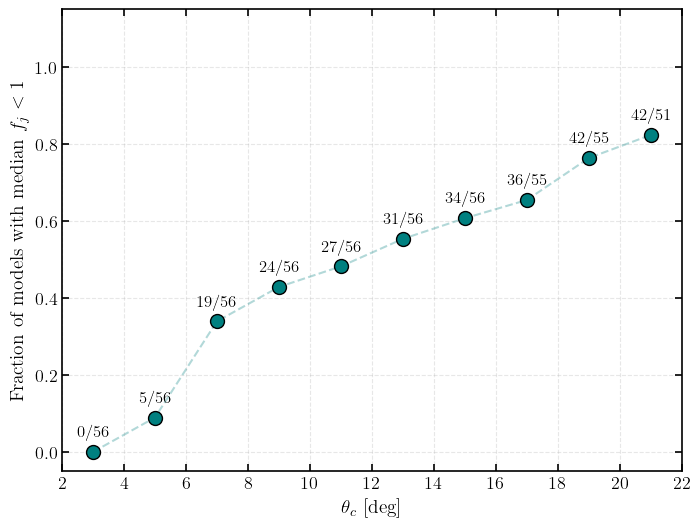

In [92]:
plotter_theta_c.plot_valid_fraction_vs_theta()

Saved plot to Output_files/ProductionPop_Theta_c_10k/fj_fraction_vs_rate.pdf


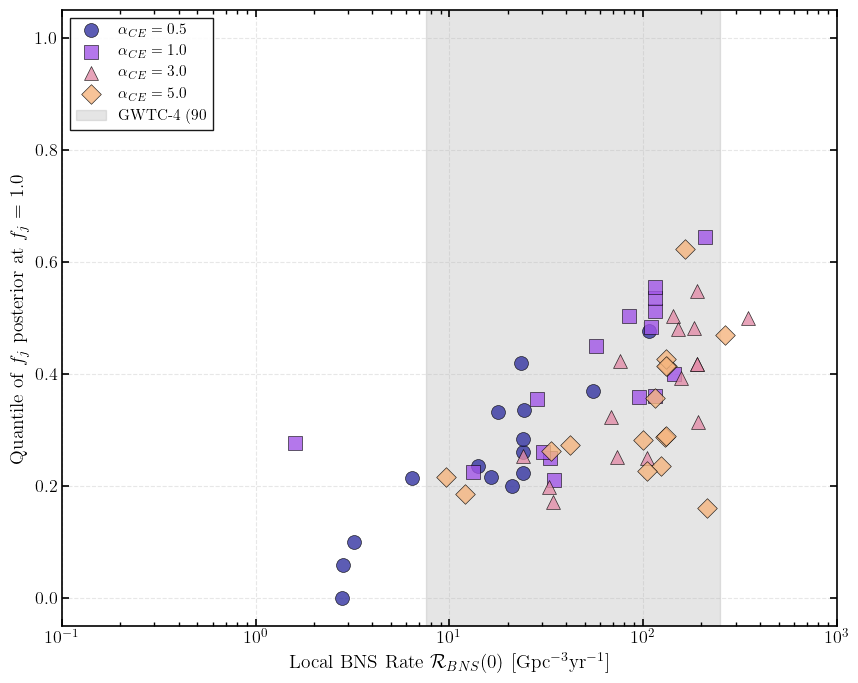

Saved plot to Output_files/ProductionPop_Theta_c_10k/theta_boundary_vs_rate.pdf


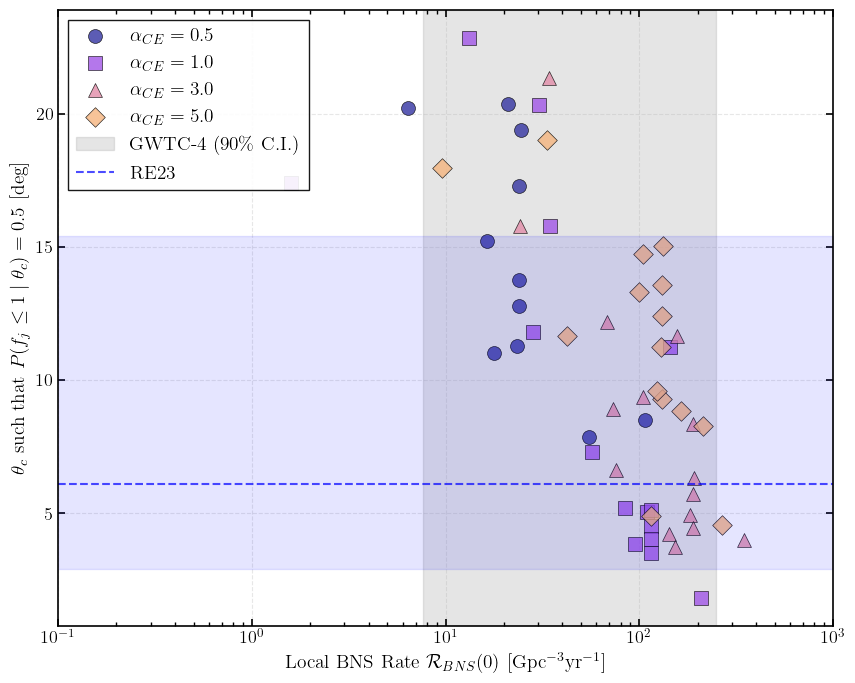

(<Figure size 1000x800 with 1 Axes>,
 <Axes: xlabel='Local BNS Rate $\\mathcal{R}_{BNS}(0)$ [Gpc$^{-3}$yr$^{-1}$]', ylabel='$\\theta_{c}$ such that $P(f_j \\leq 1 \\mid \\theta_{c}) = 0.5$ [deg]'>)

In [64]:
plotter_theta_c.plot_fj_fraction_vs_rate()
plotter_theta_c.plot_physical_theta_boundary_vs_rate()

Saved plot to Output_files/ProductionPop_Theta_c_10k/theta_star_robust_vs_rate.pdf


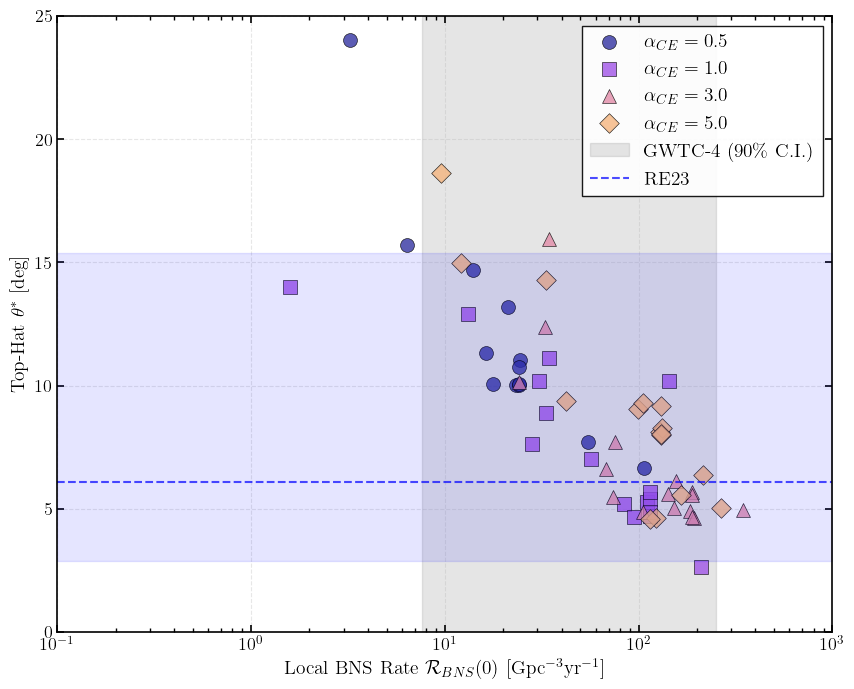

In [65]:
plotter_theta_c.plot_theta_star_robust_vs_rate()

Saved plot to Output_files/ProductionPop_Theta_c_10k/fj_violin_plot_fixed_angles.pdf


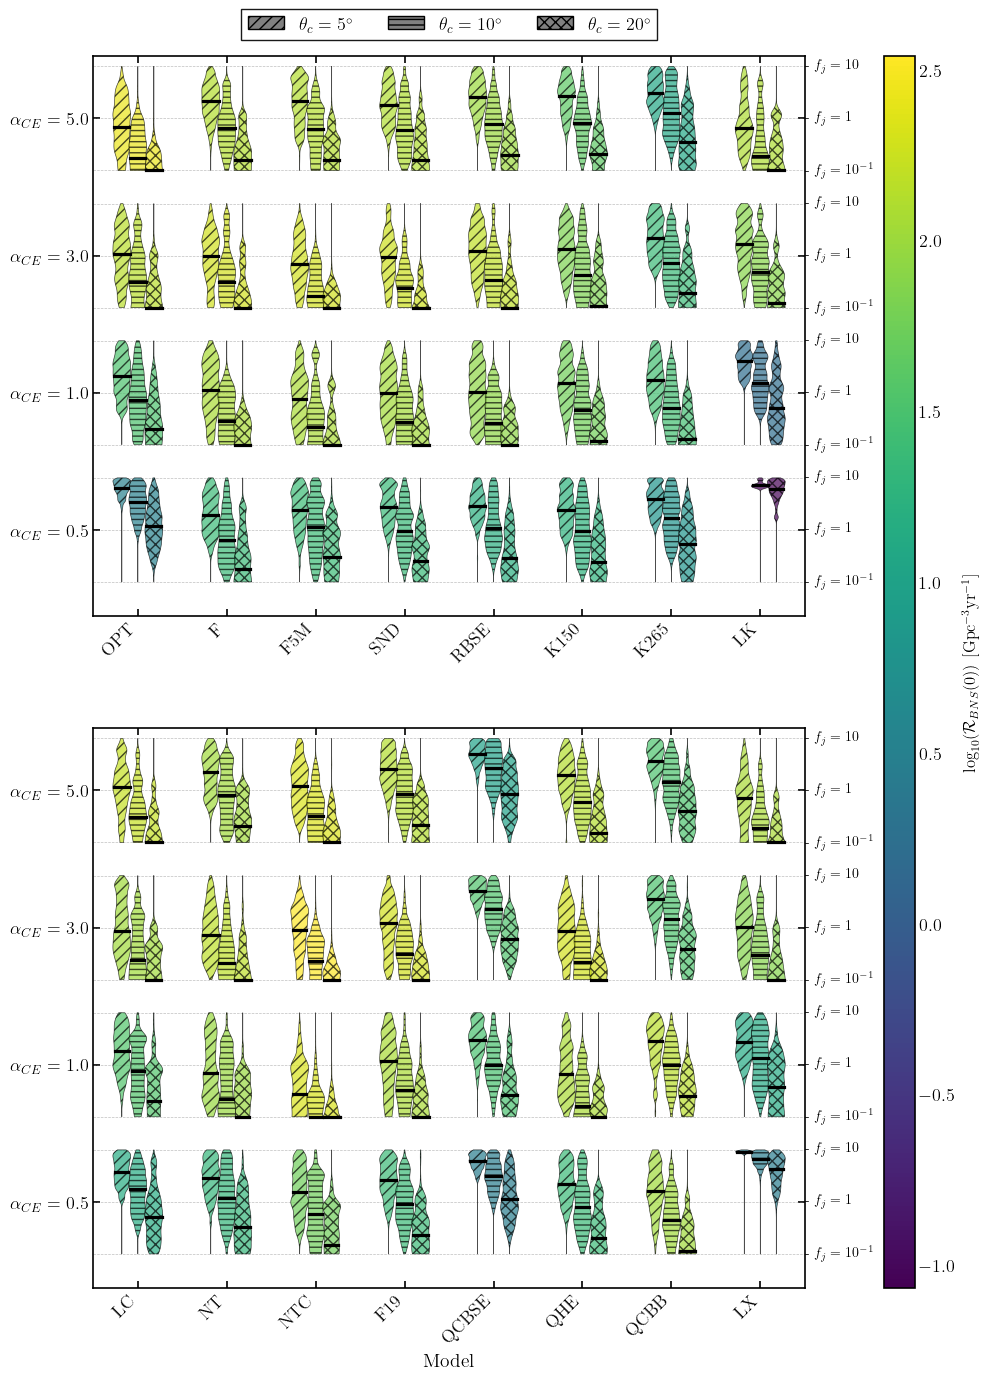

In [71]:
plotter_theta_c.plot_violins_fj_at_fixed_angles()

Saved plot to Output_files/ProductionPop_Theta_c_10k/epsilon_violin_plot.pdf


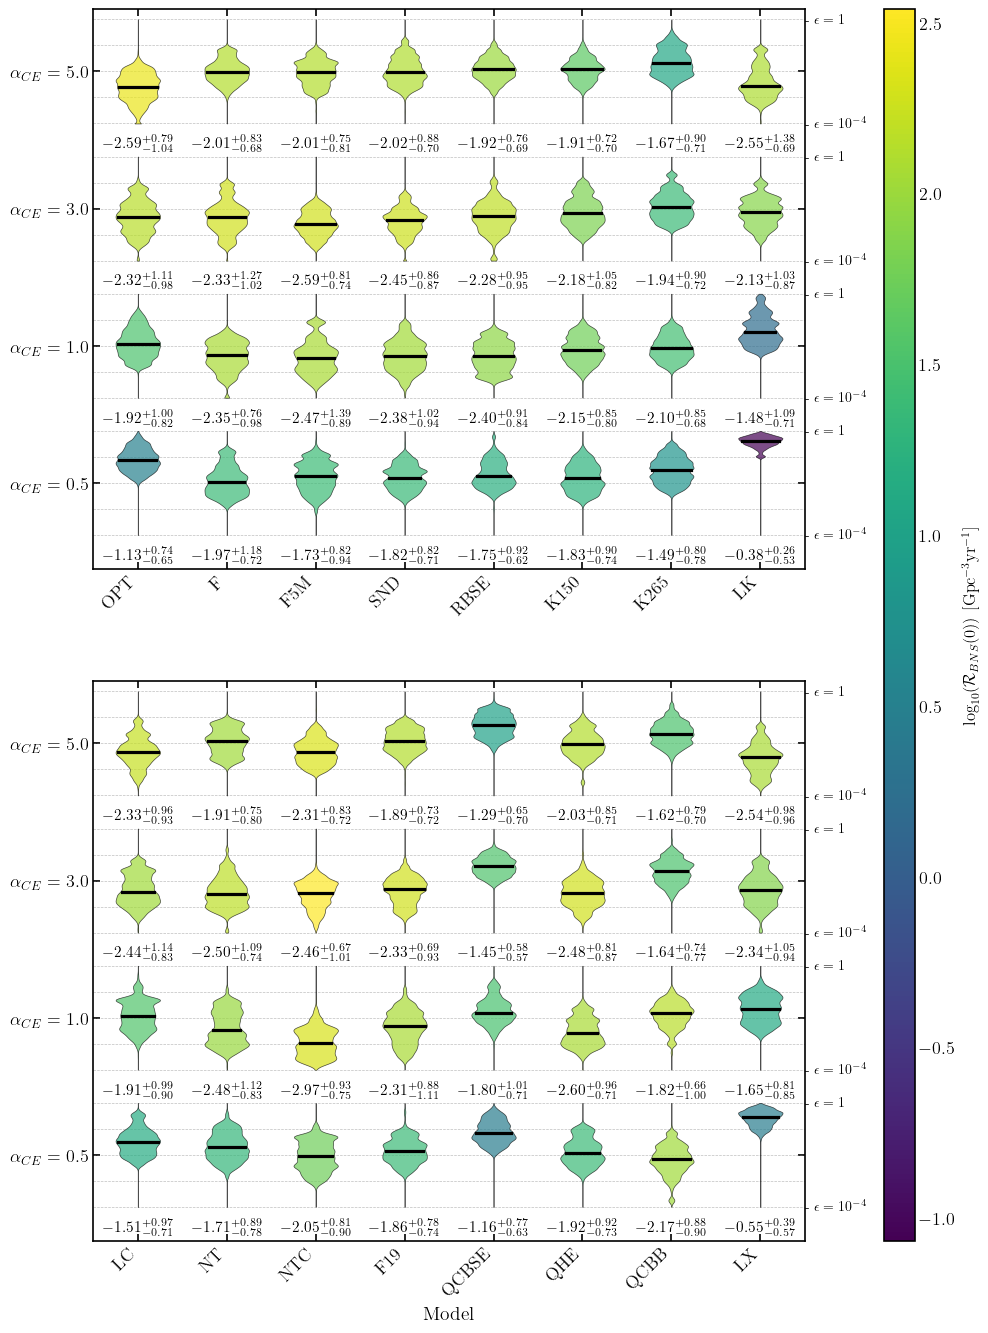

In [73]:
plotter_theta_c.plot_violins_epsilon()

Saved plot to Output_files/ProductionPop_Theta_c_10k/fj_fraction_vs_rate.pdf


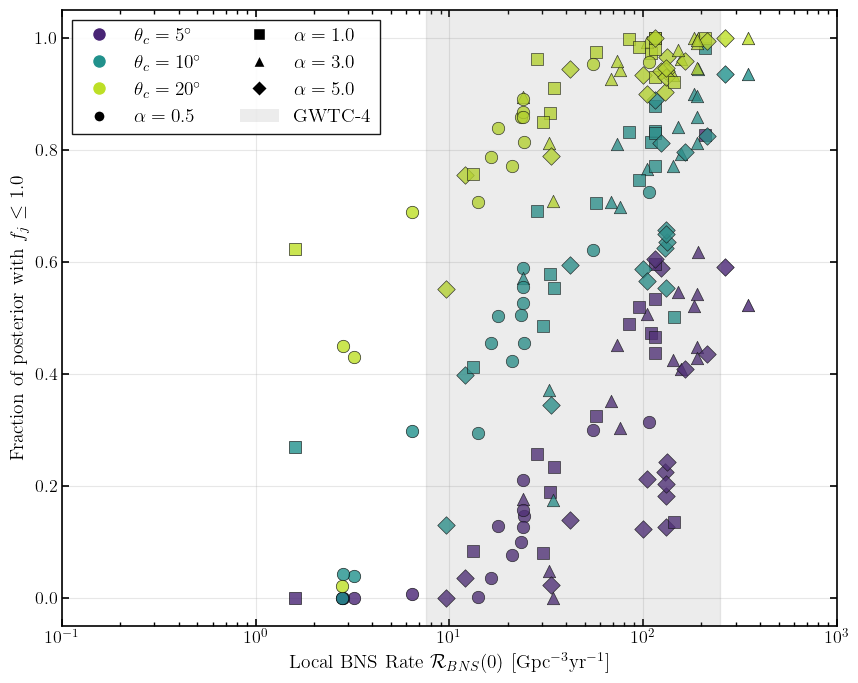

In [77]:
plotter_theta_c.plot_fj_fraction_vs_rate()

# Plotting the multiple populations

In [27]:
%load_ext autoreload
%autoreload 2

from src.plots_oop_epsilon import EpsilonModelPlotter, FjModelPlotter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
# --- OPTION 2: Plot Epsilon Results ---
run_name        = "ProductionPop_Epsilon_10k"
BASE_DIR        = Path(run_name)
OUTPUT_DIR      = Path("Output_files") / run_name
k_params        = 5

DATA_FILES_DIR  = datafiles
SAMP_NAMES      = samp_names

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
# For Epsilon models (5 parameters)
plotter_epsilon = EpsilonModelPlotter(
    samp_names=SAMP_NAMES,
    base_dir=str(BASE_DIR),
    data_files_dir=str(DATA_FILES_DIR),
    output_dir=str(OUTPUT_DIR),
    discard=5000,
    thin=20,
    k_params=5,
)

Loading and processing model data...
Successfully processed 64 models.


Saved plot to Output_files/ProductionPop_Epsilon_10k/fj_fraction_vs_rate.pdf


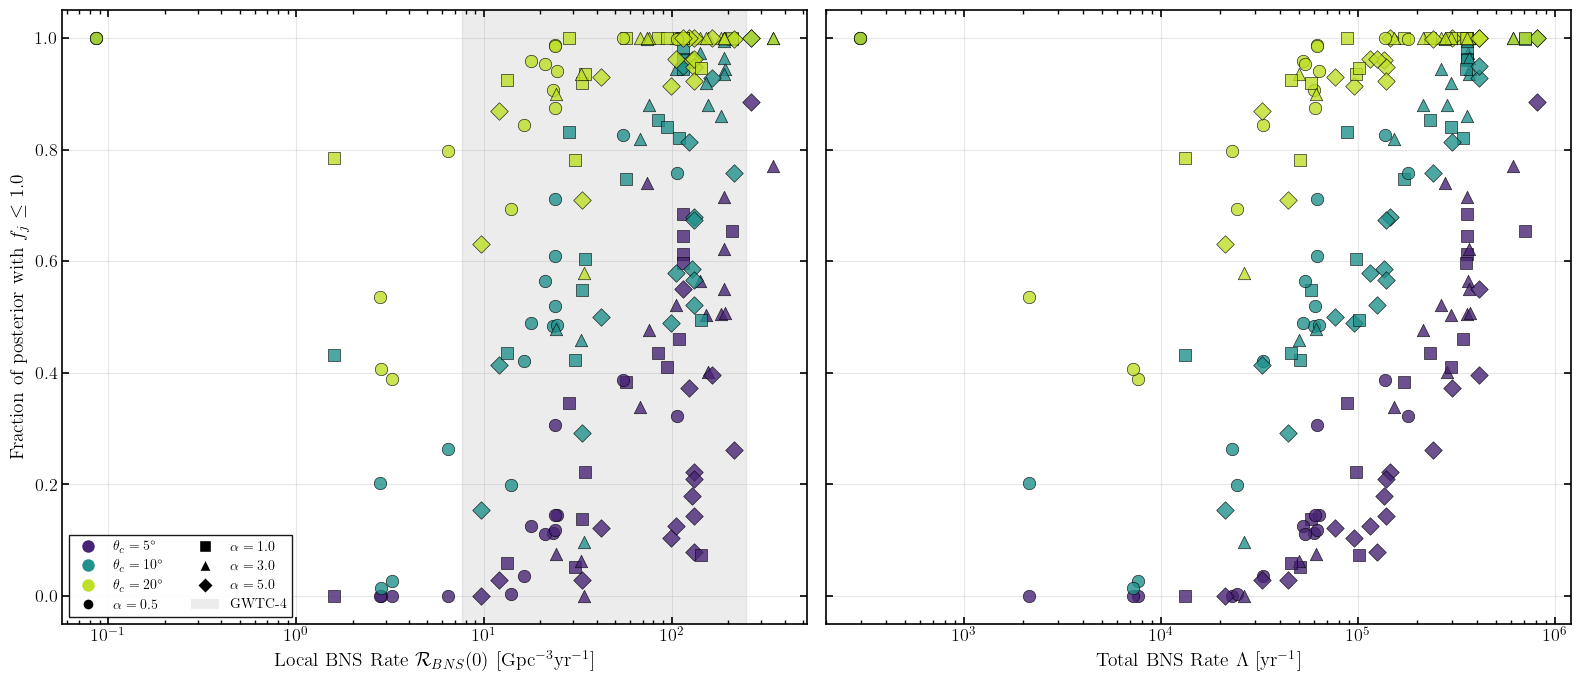

Saved plot to Output_files/ProductionPop_Epsilon_10k/theta_boundary_vs_rate.pdf


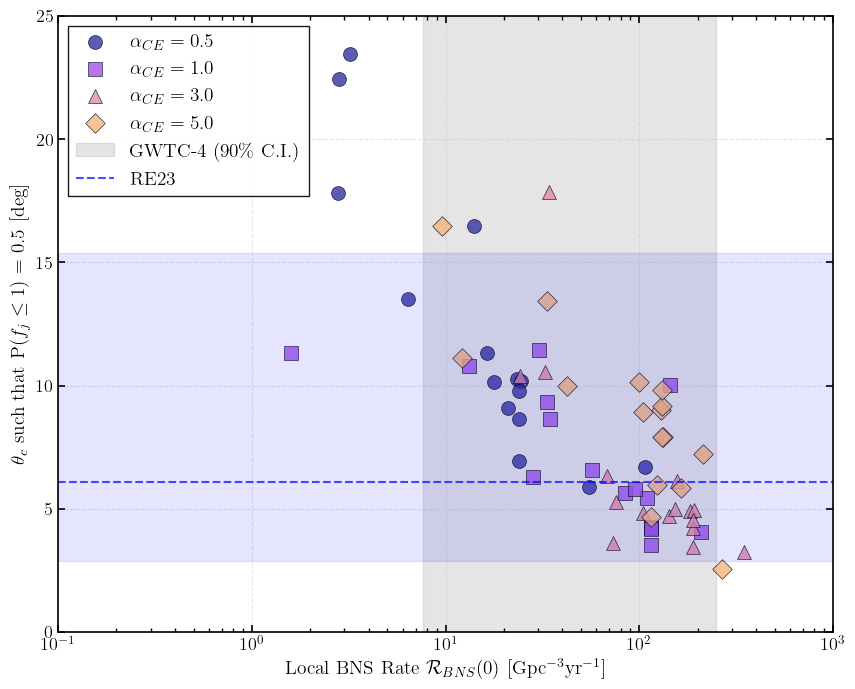

(<Figure size 1000x800 with 1 Axes>,
 <Axes: xlabel='Local BNS Rate $\\mathcal{R}_{BNS}(0)$ [Gpc$^{-3}$yr$^{-1}$]', ylabel='$\\theta_{c}$ such that P($f_j \\leq 1$) = 0.5 [deg]'>)

In [29]:
# Generate epsilon-specific plots
#plotter_epsilon.plot_violins_epsilon(filename="epsilon_violin_plot.pdf")
#plotter_epsilon.plot_violins_fj(theta_c_values=[5, 10, 20], filename="fj_violin_plot.pdf")
#plotter_epsilon.plot_fj_vs_rate(theta_c_values=[5, 10, 20], max_fj = 10)
plotter_epsilon.plot_fj_fraction_vs_rate(theta_c_values=[5, 10, 20])
plotter_epsilon.plot_physical_theta_boundary_vs_rate()

In [30]:
# For Flat Theta models (6 parameters)
run_name = "ProductionPop_Flat_10k_new_new"
BASE_DIR_FLAT   = Path(run_name)  # Make sure this is the flat theta directory
OUTPUT_DIR_FLAT = Path("Output_files") / run_name
OUTPUT_DIR_FLAT.mkdir(parents=True, exist_ok=True)

# For Flat Theta models (6 parameters)
plotter_fj = FjModelPlotter(
    samp_names  =   SAMP_NAMES,
    base_dir    =   str(BASE_DIR_FLAT),
    data_files_dir  =str(DATA_FILES_DIR),
    output_dir  =   str(OUTPUT_DIR_FLAT),
    discard     =   1000,
    thin        =   20,
    k_params    =   6,
    theta_c_idx =   4,          # Index of theta_c in parameter array
    fj_idx      =   5,          # Index of fj in parameter array
)

Loading and processing model data...
Successfully processed 64 models.


Saved plot to Output_files/ProductionPop_Flat_10k_new_new/theta_star_robust_vs_rate.pdf


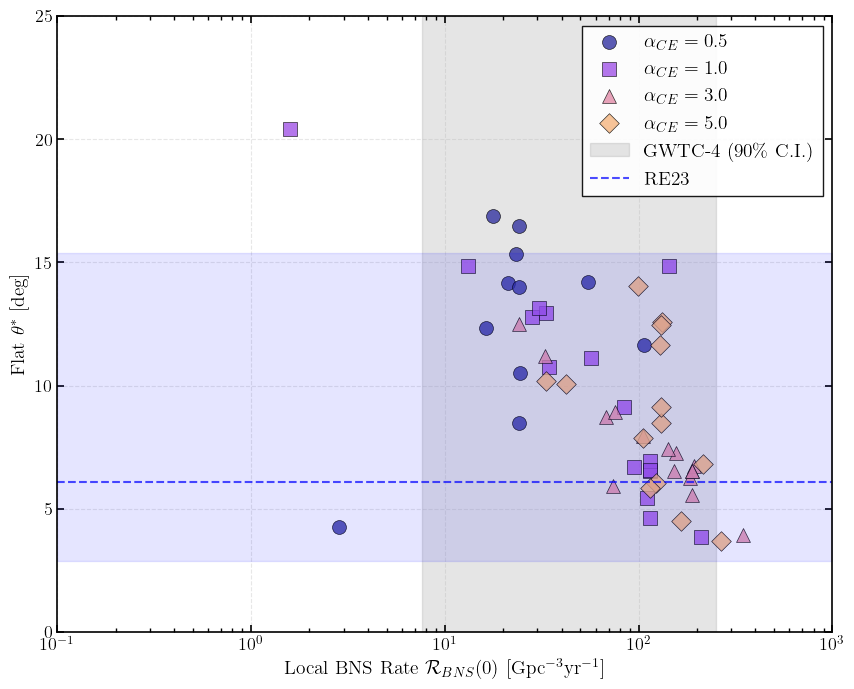

In [46]:
plotter_fj.plot_theta_star_robust_vs_rate(label_flag = 1)

Saved plot to Output_files/ProductionPop_Flat_10k_new_new/theta_boundary_vs_rate.pdf


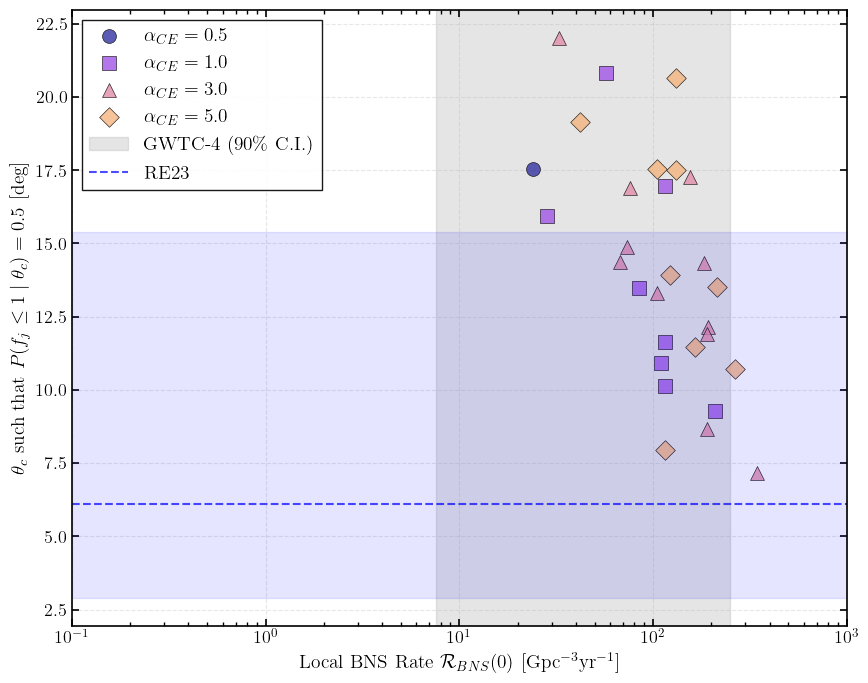

(<Figure size 1000x800 with 1 Axes>,
 <Axes: xlabel='Local BNS Rate $\\mathcal{R}_{BNS}(0)$ [Gpc$^{-3}$yr$^{-1}$]', ylabel='$\\theta_{c}$ such that $P(f_j \\leq 1 \\mid \\theta_{c}) = 0.5$ [deg]'>)

In [37]:
plotter_fj.plot_physical_theta_boundary_vs_rate()

In [ ]:
# Generate fj-specific plots
#plotter_fj.plot_violins_fj(filename="fj_violin_plot.pdf")
#plotter_fj.plot_fj_fraction_vs_rate()
#plotter_fj.plot_fj_posteriors(filename="fj_posteriors.pdf")
#plotter_fj.plot_theta_c_posteriors(filename="theta_c_posteriors.pdf")

In [34]:
%load_ext autoreload
%autoreload 2

from src.plots_oop_epsilon import LogNormalModelPlotter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
# For Log-Normal Theta models (6 parameters)
run_name = "ProductionPop_LogNorm_10k_new_new"
BASE_DIR_LN = Path(run_name)
OUTPUT_DIR_LN = Path("Output_files") / run_name
OUTPUT_DIR_LN.mkdir(parents=True, exist_ok=True)

plotter_ln = LogNormalModelPlotter(
    samp_names=SAMP_NAMES,
    base_dir=str(BASE_DIR_LN),
    data_files_dir=str(DATA_FILES_DIR),
    output_dir=str(OUTPUT_DIR_LN),
    discard=300,
    thin=20,
    k_params=6,
    theta_c_idx=4,  # Index of log10(theta_c_median)
    fj_idx=5,
)

Loading and processing model data...
Successfully processed 64 models.


Could not compute theta* for model fiducial_klencki_A0.5
Could not compute theta* for model fiducial_Hrad_A1.0
Could not compute theta* for model fiducial_klencki_A1.0
Could not compute theta* for model fiducial_HGoptimistic_A3.0
Could not compute theta* for model fiducial_notides_pericirc_A3.0
Could not compute theta* for model fiducial_kick265_A5.0
Could not compute theta* for model fiducial_l01_A5.0
Could not compute theta* for model fiducial_xuli_A5.0
Saved plot to Output_files/ProductionPop_LogNorm_10k_new_new/theta_star_robust_vs_rate.pdf


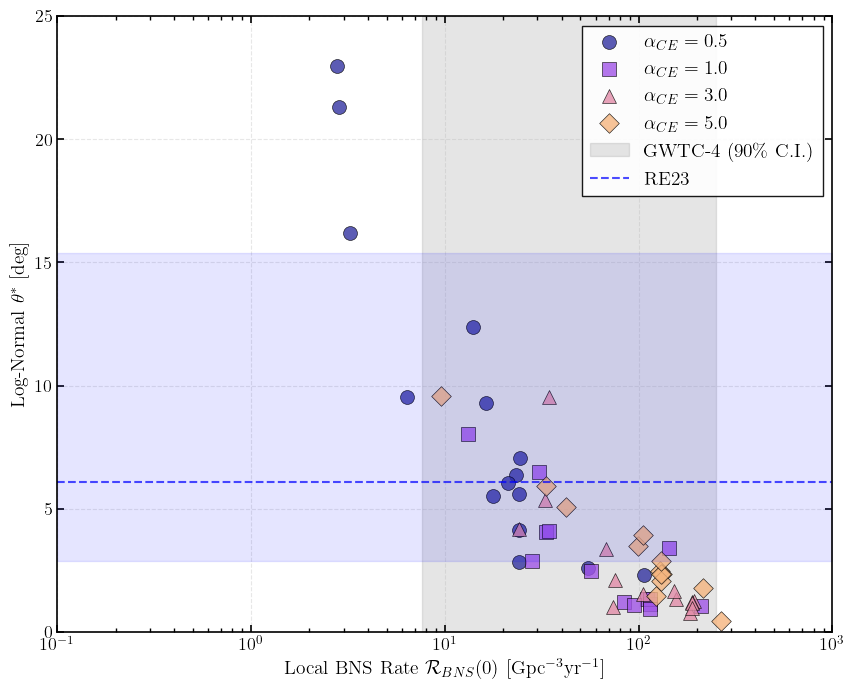

Saved plot to Output_files/ProductionPop_LogNorm_10k_new_new/lognormal_tail_fraction_vs_rate.pdf


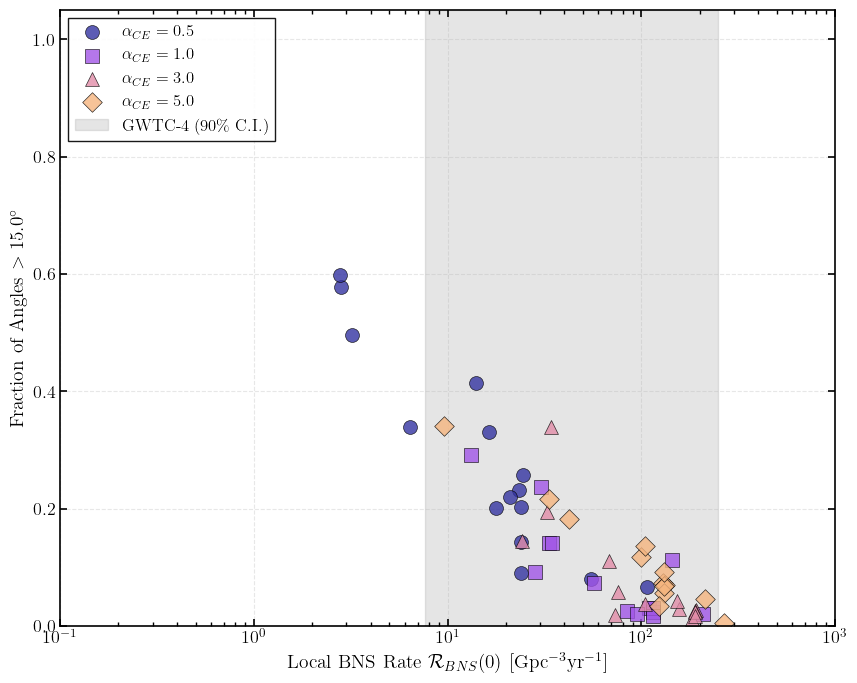

(<Figure size 1000x800 with 1 Axes>,
 <Axes: xlabel='Local BNS Rate $\\mathcal{R}_{BNS}(0)$ [Gpc$^{-3}$yr$^{-1}$]', ylabel='Fraction of Angles $> 15.0^\\circ$'>)

In [ ]:
plotter_ln.plot_theta_star_robust_vs_rate(label_flag=2)


Saved plot to Output_files/ProductionPop_LogNorm_10k_new_new/lognormal_tail_fraction_vs_rate.pdf


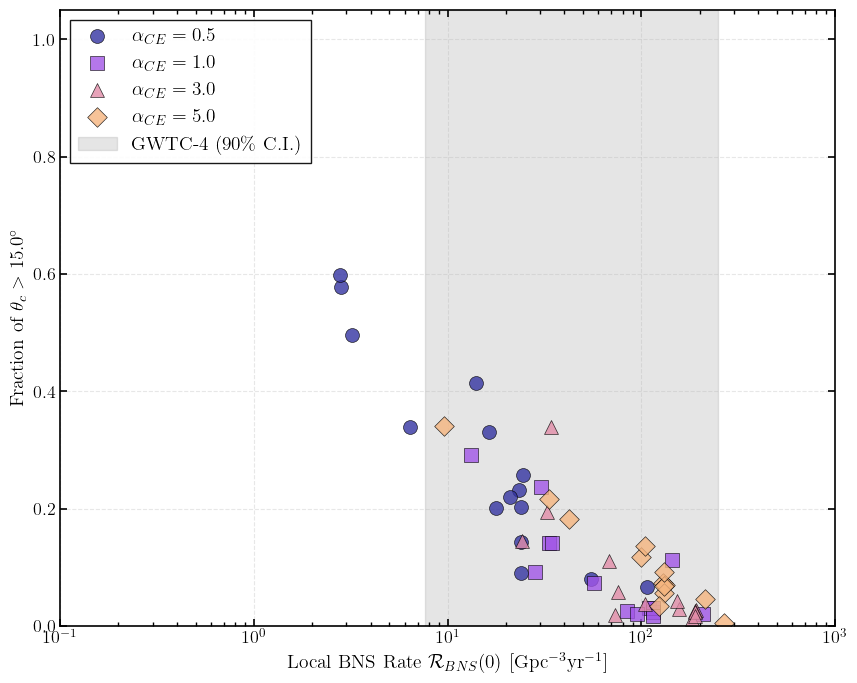

(<Figure size 1000x800 with 1 Axes>,
 <Axes: xlabel='Local BNS Rate $\\mathcal{R}_{BNS}(0)$ [Gpc$^{-3}$yr$^{-1}$]', ylabel='Fraction of $\\theta_c > 15.0^\\circ$'>)

In [60]:
plotter_ln.plot_lognormal_tail_fraction_vs_rate()

Saved plot to Output_files/ProductionPop_LogNorm_10k_new_new/theta_boundary_vs_rate.pdf


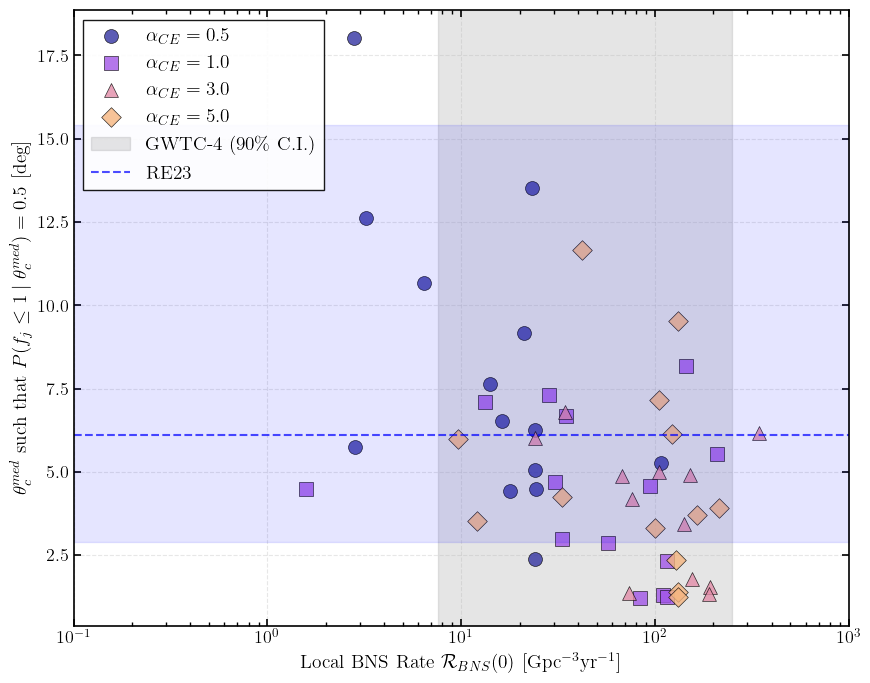

(<Figure size 1000x800 with 1 Axes>,
 <Axes: xlabel='Local BNS Rate $\\mathcal{R}_{BNS}(0)$ [Gpc$^{-3}$yr$^{-1}$]', ylabel='$\\theta_{c}^{med}$ such that $P(f_j \\leq 1 \\mid \\theta_{c}^{med}) = 0.5$ [deg]'>)

In [ ]:
plotter_ln.plot_physical_theta_boundary_vs_rate()

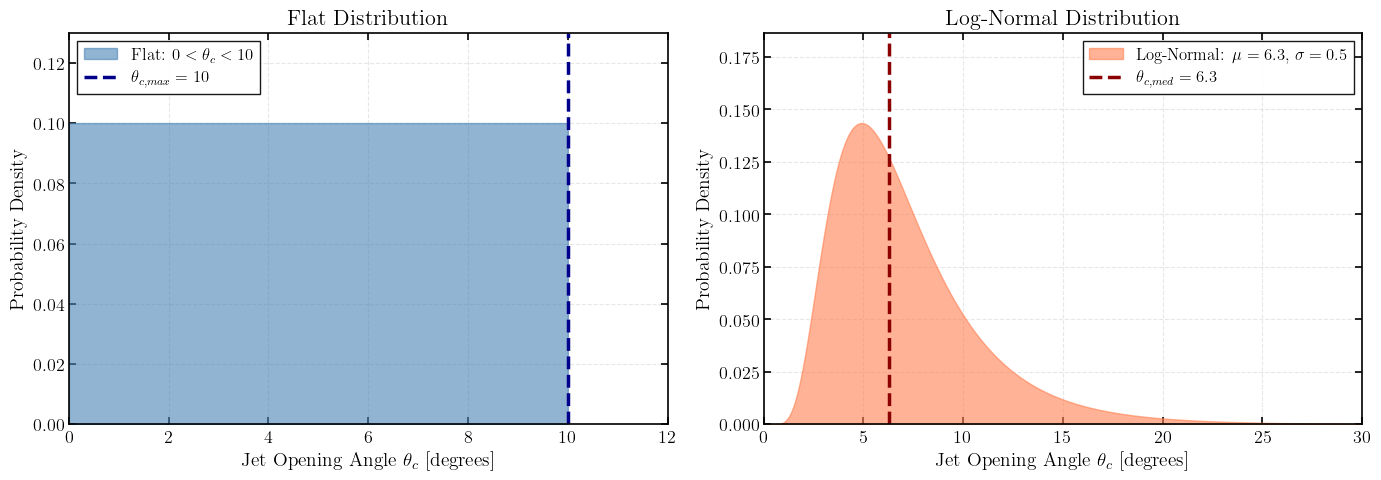

In [ ]:
# Add this cell to your notebook
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm

def plot_jet_angle_distributions(theta_c_max=10, theta_c_med=6.3, sigma_theta=0.5, figsize=(14, 5)):
    """
    Plot flat and log-normal jet angle distributions side by side.
    
    Parameters:
    -----------
    theta_c_max : float
        Maximum jet opening angle for flat distribution (degrees)
    theta_c_med : float
        Median jet opening angle for log-normal distribution (degrees)
    sigma_theta : float
        Standard deviation parameter for log-normal distribution
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # ========== LEFT PANEL: Flat Distribution ==========
    theta_flat = np.linspace(0, theta_c_max, 1000)
    pdf_flat = np.ones_like(theta_flat) / theta_c_max  # Uniform distribution
    
    ax1.fill_between(theta_flat, 0, pdf_flat, alpha=0.6, color='steelblue', 
                     label=f'Flat: $0° < \\theta_c < {theta_c_max}°$')
    ax1.axvline(theta_c_max, color='darkblue', linestyle='--', linewidth=2.5, 
                label=f'$\\theta_{{c,max}} = {theta_c_max}°$')
    
    ax1.set_xlabel('Jet Opening Angle $\\theta_c$ [degrees]', fontsize=14)
    ax1.set_ylabel('Probability Density', fontsize=14)
    ax1.set_title('Flat Distribution', fontsize=16, weight='bold')
    ax1.set_xlim(0, theta_c_max * 1.2)
    ax1.set_ylim(0, max(pdf_flat) * 1.3)
    ax1.legend(fontsize=12, loc='upper left')
    ax1.grid(True, alpha=0.3, linestyle='--')
    
    # ========== RIGHT PANEL: Log-Normal Distribution ==========
    # Log-normal parameters: if median is theta_c_med, then mu = log(theta_c_med)
    mu = np.log(theta_c_med)
    theta_ln = np.linspace(0.1, theta_c_max * 3, 1000)
    
    # SciPy's lognorm uses: scale=exp(mu), s=sigma
    pdf_ln = lognorm.pdf(theta_ln, s=sigma_theta, scale=np.exp(mu))
    
    ax2.fill_between(theta_ln, 0, pdf_ln, alpha=0.6, color='coral', 
                     label=f'Log-Normal: $\\mu = {theta_c_med:.1f}°$, $\\sigma = {sigma_theta}$')
    ax2.axvline(theta_c_med, color='darkred', linestyle='--', linewidth=2.5, 
                label=f'$\\theta_{{c,med}} = {theta_c_med:.1f}°$')
    
    ax2.set_xlabel('Jet Opening Angle $\\theta_c$ [degrees]', fontsize=14)
    ax2.set_ylabel('Probability Density', fontsize=14)
    ax2.set_title('Log-Normal Distribution', fontsize=16, weight='bold')
    ax2.set_xlim(0, theta_c_max * 3)
    ax2.legend(fontsize=12, loc='upper right')
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.set_ylim(0, max(pdf_ln) * 1.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig, (ax1, ax2)

# Example usage:
fig, axes = plot_jet_angle_distributions(theta_c_max=10, theta_c_med=6.3, sigma_theta=0.5)

Saved plot to Output_files/ProductionPop_LogNorm_10k_new_new/fj_violin_plot.pdf


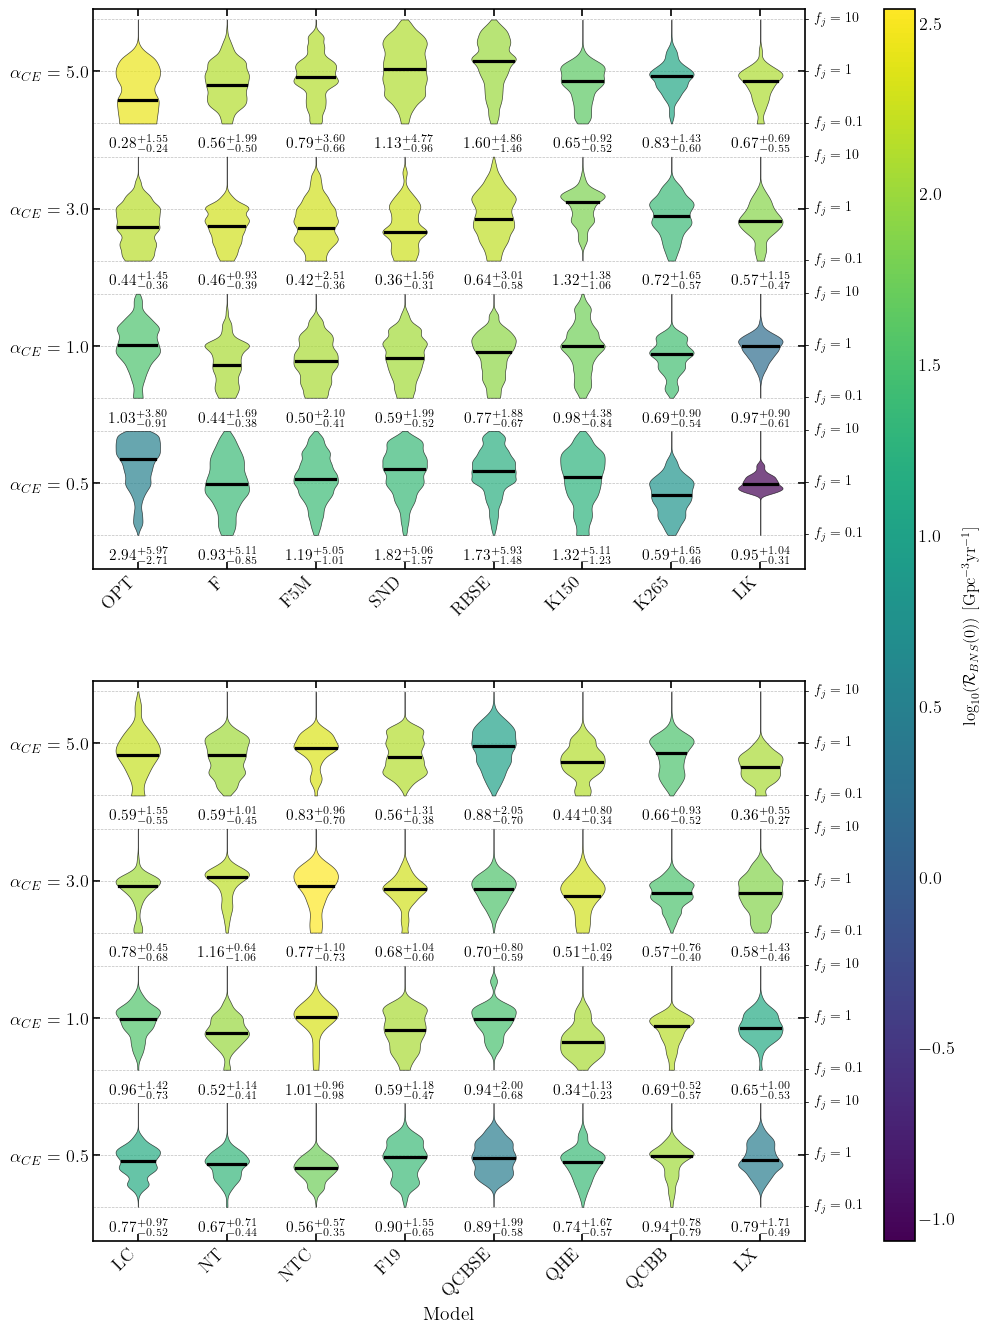

Saved plot to Output_files/ProductionPop_LogNorm_10k_new_new/fj_fraction_vs_rate.pdf


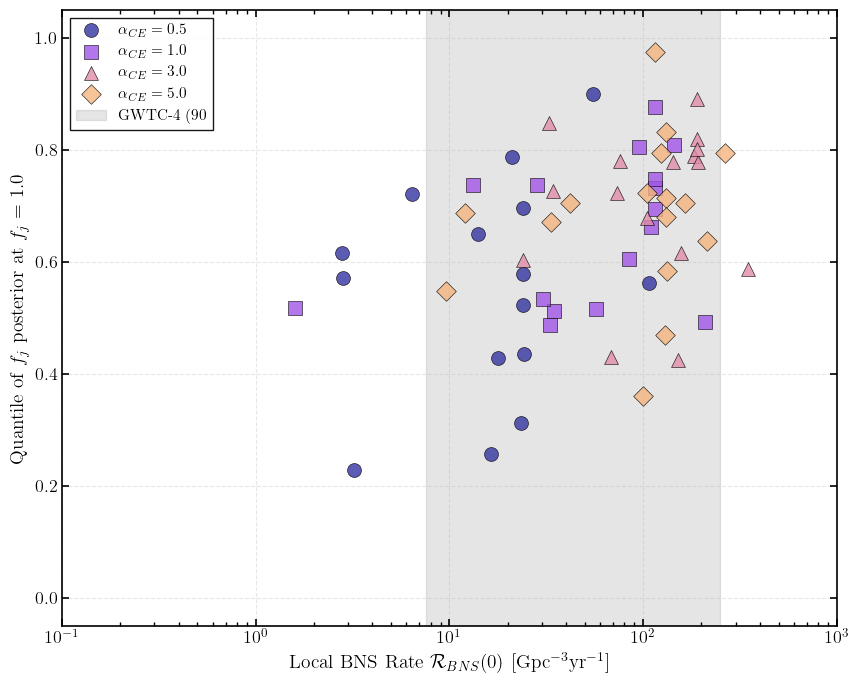

Saved plot to Output_files/ProductionPop_LogNorm_10k_new_new/theta_c_vs_fj_scatter.pdf


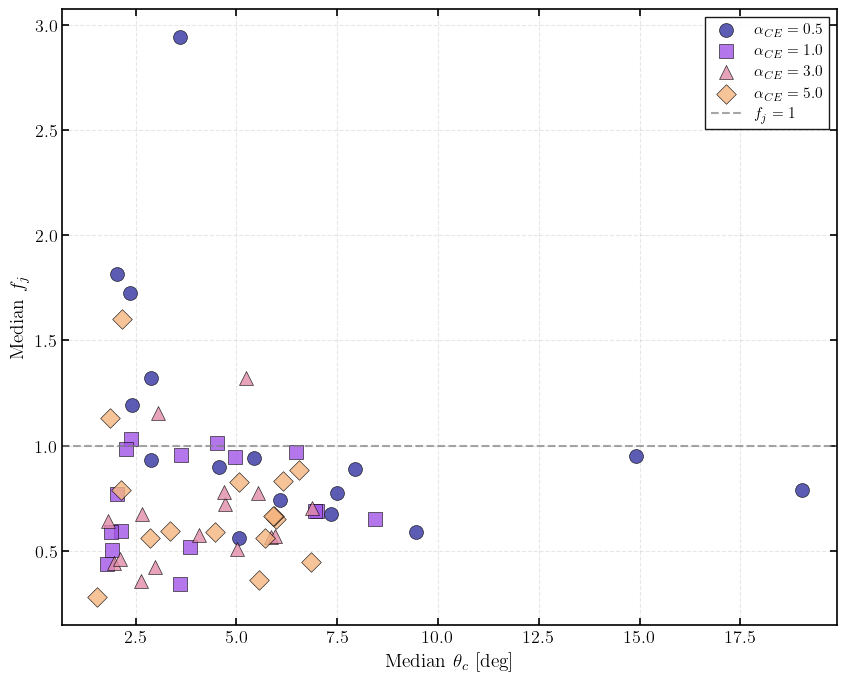

(<Figure size 1000x800 with 1 Axes>,
 <Axes: xlabel='Median $\\theta_c$ [deg]', ylabel='Median $f_j$'>)

In [ ]:
# Generate plots
plotter_ln.plot_violins_fj(filename="fj_violin_plot.pdf", max_fj=10)
plotter_ln.plot_fj_fraction_vs_rate()
plotter_ln.plot_theta_c_vs_fj(show_errorbars=False)

Saved plot to Output_files/ProductionPop_LogNorm_10k_new_new/theta_c_times_fj_vs_rate.pdf


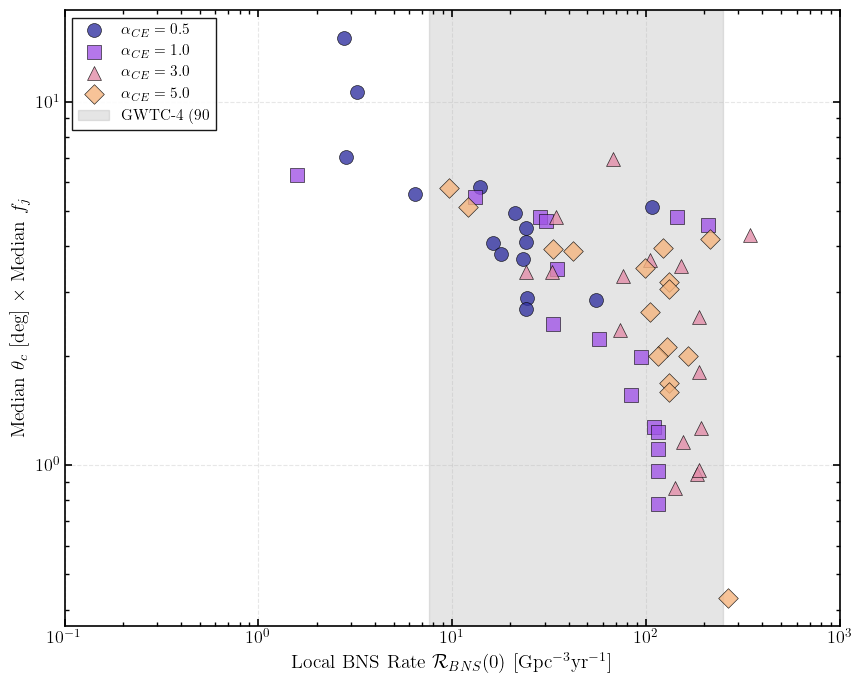

Saved plot to Output_files/ProductionPop_LogNorm_10k_new_new/sgrb_rate_vs_local_rate_lognormal.pdf


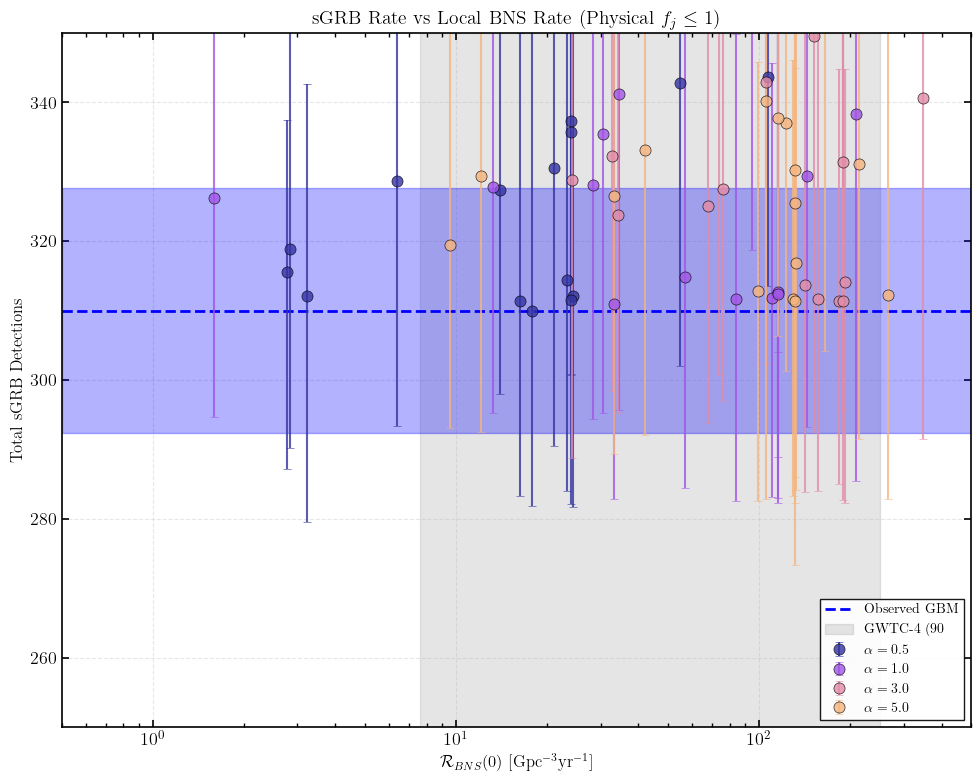

(<Figure size 1000x800 with 1 Axes>,
 <Axes: title={'center': 'sGRB Rate vs Local BNS Rate (Physical $f_j \\leq 1$)'}, xlabel='$\\mathcal{R}_{BNS}(0)$ [Gpc$^{-3}$yr$^{-1}$]', ylabel='Total sGRB Detections'>)

In [ ]:
plotter_ln.plot_theta_c_times_fj_vs_rate()
plotter_ln.plot_sgrb_rate_vs_local_rate(geom = geom_eff_interp)

In [ ]:
1/0

ZeroDivisionError: division by zero

In [ ]:
# Generate the plots
#print("\n--- Generating f_j vs. Rate Plot ---")
#plotter.plot_fj_vs_rate()

#print("\n--- Generating Model Probability Grid Plot ---")

#print("\n--- Generating AIC vs. Epsilon Plot ---")
#plotter.plot_aic_vs_epsilon() 

#print("\n--- Generating f_j Violin Plot ---")
#plotter.plot_violins(plot_type="fj", filename="fj_violin_plot.pdf")

#print("\n--- Generating Epsilon Violin Plot ---")
#plotter.plot_violins(plot_type="epsilon", filename="epsilon_violin_plot.pdf")


#plotter.plot_probability_grid_epsilon(filename="probability_grid_epsilon.pdf")

#plotter.plot_combined_mrd_rates_theta_c(
#    theta_c_values=[5.0, 10.0, 20.0],
#    datafiles_path=Path("datafiles"),
#    filename="combined_mrd_rates_theta_c.pdf"
#)

#epsilon_fj_table = plotter.create_epsilon_fj_table(
#    theta_c_values=[3.4]#[5, 10, 20]
#)

#plotter.print_and_plot_top_models(top_n=5, theta_c_values=[3.4, 5.0])
#plotter.plot_probability_grid()
#plotter.plot_combined_mrd_rates_theta_c()

plotter.plot_probability_vs_r0(filename="probability_vs_r0_flat_theta_c.pdf")

NameError: name 'plotter' is not defined

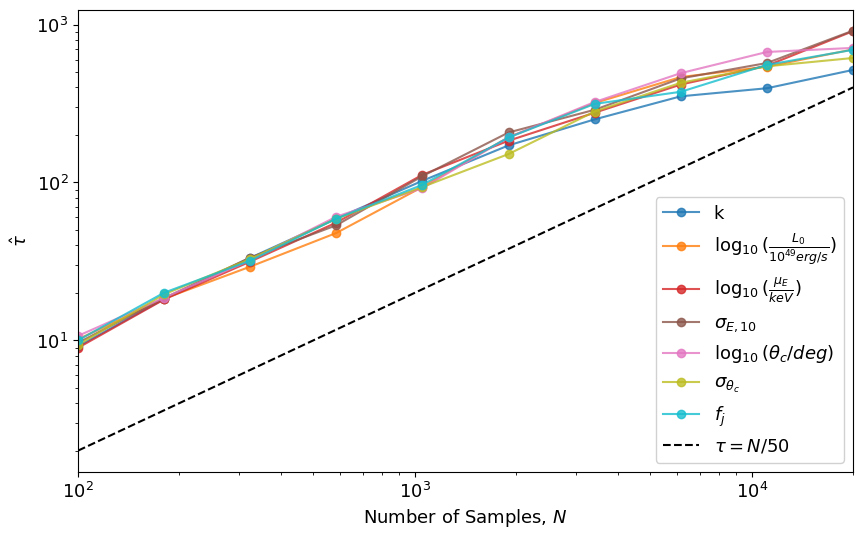

In [ ]:
from src import plots_oop
plotter = plots_oop.MCMCPlotter(
        samplers    =   [backend],
        names       =   ['Fiducial Model'],
        output_dir  =   output_dir,
        burn_in     =   300, # Discard the first 1000 steps
        thin        =   15,
        labels     =   labels,
)

plotter.plot_autocorrelation_times()

Here you can see if there are any strange features in the likelihood terms, usually it quickly (or if you are lucky immediately) converges and oscillates according to the posteriors. 

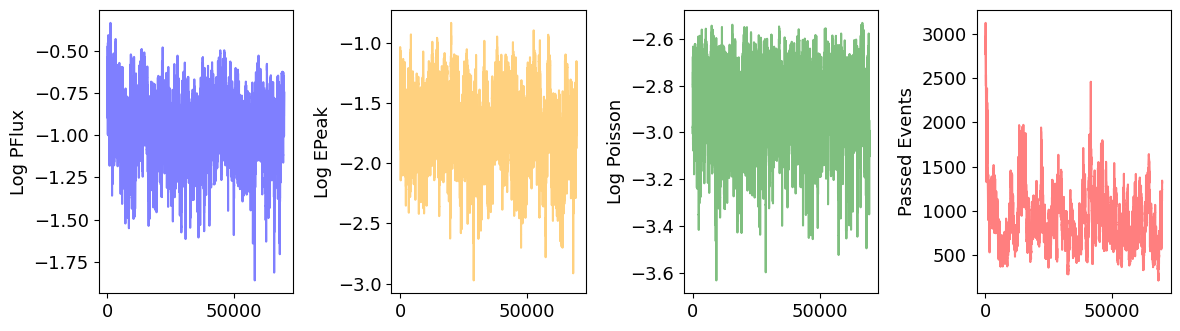

In [ ]:
# plot the blobs 

blobs = backend.get_blobs(discard=300, flat=True)
l_pflux = blobs["l_pflux"]
l_epeak = blobs["l_epeak"]
l_poiss = blobs["l_poiss"]
effciency = blobs["l_eff"]

def running_avg(arr, window_size=300):
    """Calculate the running average of an array."""
    return np.convolve(arr, np.ones(window_size)/window_size, mode='valid')

l_pflux, l_epeak, l_poiss, effciency = [
    running_avg(arr) for arr in [l_pflux, l_epeak, l_poiss, effciency]
]

steps = np.arange(len(l_pflux)) / n_walkers  # Divide by nwalkers to get the step number

fig, axs = plt.subplots(1, 4, figsize=(12, 3.5))
axs[0].plot(steps, l_pflux, label='Log PFlux', color='blue', alpha=0.5)
axs[0].set_ylabel('Log PFlux')
axs[1].plot(steps, l_epeak, label='Log EPeak', color='orange', alpha=0.5)
axs[1].set_ylabel('Log EPeak')
axs[2].plot(steps, l_poiss, label='Log Poisson', color='green', alpha=0.5)
axs[2].set_ylabel('Log Poisson')
axs[3].plot(steps, effciency * 25e3, color='red', alpha=0.5)
axs[3].set_ylabel('Passed Events')

plt.tight_layout()
plt.savefig(output_dir / "blobs_evolution.png")
plt.show()  

The following prepares the emprical cdfs.

In [ ]:
# take the last 100 samples
flat_samples = sampler.get_chain(discard=300, thin=20, flat=True)
last_samples = flat_samples[-200:]

# extract the parameters
p_flx   = []
e_pk    = []
rates   = []
for i, theta in enumerate(last_samples) :
    epsilon         = theta[-1]
    gbm_eff         = 0.6 # this is the efficiency of the GBM detector
    grbs_per_year   = epsilon * len(default_params.z_arr) * gbm_eff # Number of GRBs per year in the whole universe

    #poiss ncertaintey
    n_events    = 10_000 #default_params.rng.poisson(grbs_per_year * YEARS * geo_factor * gbm_eff)
    results     = simplified_montecarlo(theta, n_events)

    # Calculate the log likelihood
    p_flux_sim  = results["p_flux"] # erg to keV to as to have adimensional ph / cm2 / s
    z_arr_sim   = results["z_arr"]
    E_p_obs_sim = results["E_p_obs"] 

    mask = (
        (p_flux_sim > 4) & 
        (E_p_obs_sim > 50) & 
        (E_p_obs_sim < 10_000)
    )

    p_flux_sim  = p_flux_sim[mask]
    E_p_obs_sim = E_p_obs_sim[mask]

    p_flx.append(p_flux_sim)
    e_pk.append(E_p_obs_sim)

    number_of_years_simulated = n_events / (grbs_per_year)  # Number of years we simulated

    observed_rate   = sum(p_flux_sim > 4) / number_of_years_simulated  # Measured rate of events per year per simulation

    rates.append(observed_rate)
    
def empirical_cdf(data):
    """Compute the empirical cumulative distribution function (CDF) of the data."""
    sorted_data = np.sort(data)
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    return sorted_data, cdf

# Plot the empirical CDF of the simulated data vs real data
p_flx   = np.concatenate(p_flx)
e_pk    = np.concatenate(e_pk)

p_flx_emp, cdf_p_flx    = empirical_cdf(p_flx)
e_pk_emp, cdf_e_pk      = empirical_cdf(e_pk)

p_flx_emp_data, cdf_p_flx_data  = empirical_cdf(default_params.pflux_data)
e_pk_emp_data, cdf_e_pk_data    = empirical_cdf(default_params.epeak_data)

Compare the actual CDFs of the simulated data with the ones from the real data.

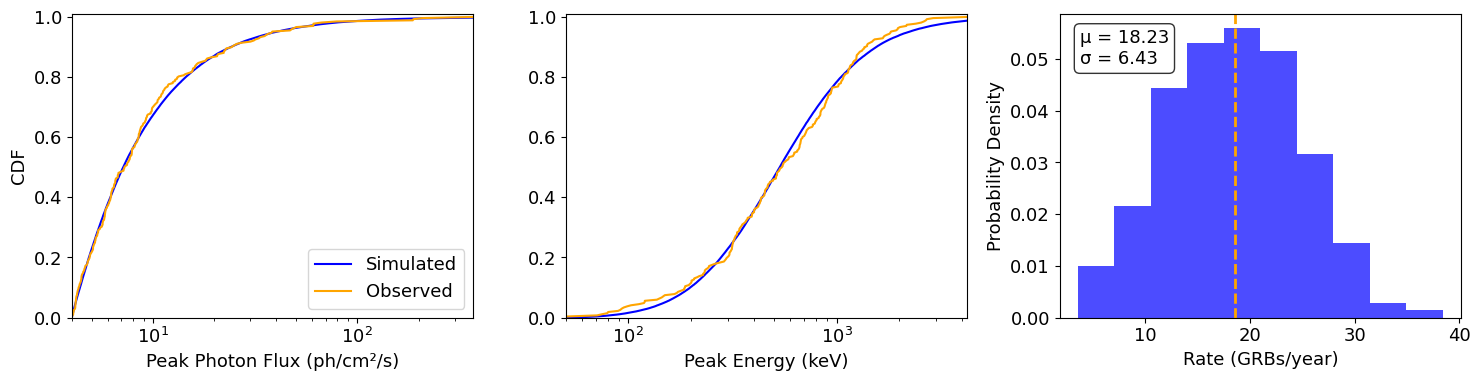

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# First plot: Peak Photon Flux CDF
axs[0].plot(p_flx_emp, cdf_p_flx, label='Simulated', color='blue')
axs[0].plot(p_flx_emp_data, cdf_p_flx_data, label='Observed', color='orange')
axs[0].set_xlabel(r"Peak Photon Flux (ph/cm²/s)")
axs[0].set_ylabel('CDF')
axs[0].legend()
axs[0].set_xscale('log')
axs[0].set_xlim(4, max(default_params.pflux_data))
axs[0].set_ylim(0, 1.01)

# Second plot: Peak Energy CDF
axs[1].plot(e_pk_emp, cdf_e_pk, label='Simulated', color='blue')
axs[1].plot(e_pk_emp_data, cdf_e_pk_data, label='Observed', color='orange')
axs[1].set_xlabel(r'Peak Energy (keV)')
axs[1].set_xscale('log')
axs[1].set_xlim(50, max(default_params.epeak_data))
axs[1].set_ylim(0, 1.01)

# Third plot: Rate comparison (Poisson process)
axs[2].hist(rates, bins=10, alpha=0.7, label='Simulated Rates', color='blue', density=True)
axs[2].axvline(default_params.yearly_rate, color='orange', linestyle='--', linewidth=2, 
               label=f'Expected Rate\n({default_params.yearly_rate:.2f} GRBs/year)')
axs[2].set_xlabel('Rate (GRBs/year)')
axs[2].set_ylabel('Probability Density')
axs[2].text(0.05, 0.95, f'μ = {np.mean(rates):.2f}\nσ = {np.std(rates):.2f}', 
            transform=axs[2].transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig(output_dir / "combined_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Multiple populations

# Old

In [ ]:
# --- OPTION 2: Plot Epsilon Results ---
run_name        = "ProductionPop_25_deg_linear_luminosity"
BASE_DIR        = Path(run_name)
OUTPUT_DIR      = Path("Output_files") / run_name
k_params        = 5

DATA_FILES_DIR  = datafiles
SAMP_NAMES      = samp_names

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
# For Epsilon models (5 parameters)
plotter_epsilon = EpsilonModelPlotter(
    samp_names=SAMP_NAMES,
    base_dir=str(BASE_DIR),
    data_files_dir=str(DATA_FILES_DIR),
    output_dir  =str(OUTPUT_DIR),
    discard     =   300,
    thin        =   15,
    k_params=5,
)

Loading and processing model data...
Successfully processed 64 models.


Saved plot to Output_files/ProductionPop_25_deg_linear_luminosity/sgrb_rate_vs_local_rate_epsilon.pdf


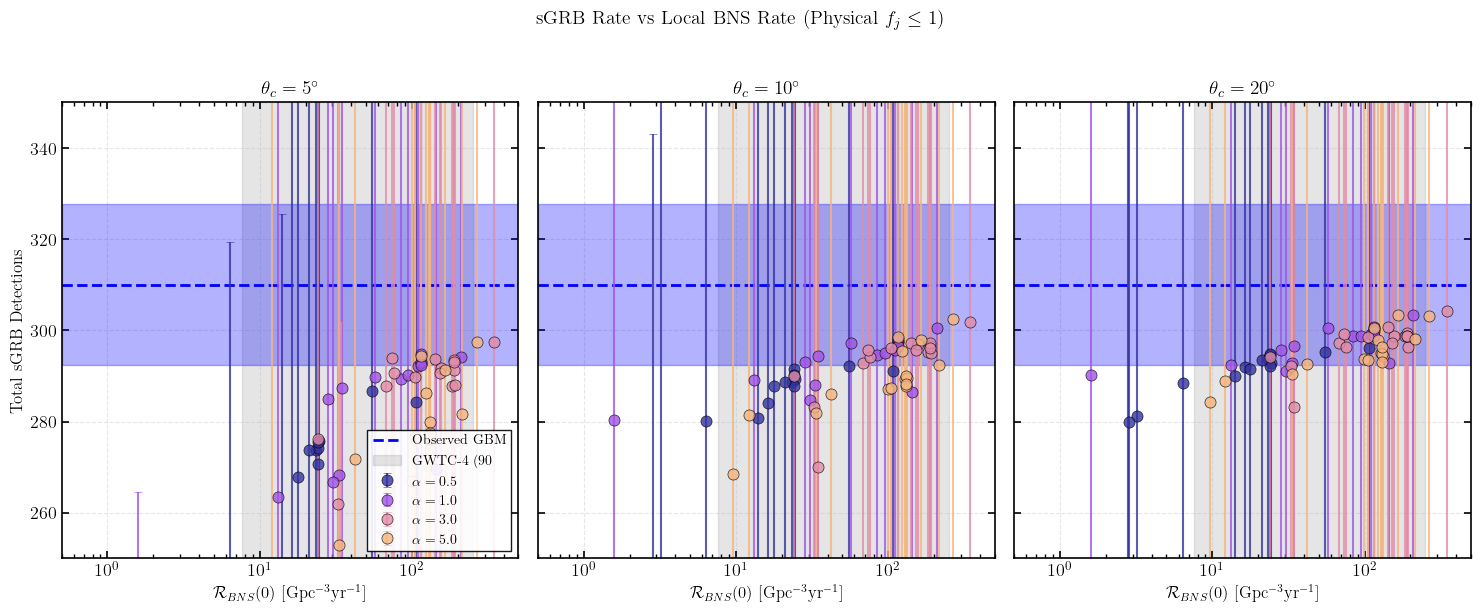

(<Figure size 1500x600 with 3 Axes>,
 array([<Axes: title={'center': '$\\theta_c = 5^\\circ$'}, xlabel='$\\mathcal{R}_{BNS}(0)$ [Gpc$^{-3}$yr$^{-1}$]', ylabel='Total sGRB Detections'>,
        <Axes: title={'center': '$\\theta_c = 10^\\circ$'}, xlabel='$\\mathcal{R}_{BNS}(0)$ [Gpc$^{-3}$yr$^{-1}$]'>,
        <Axes: title={'center': '$\\theta_c = 20^\\circ$'}, xlabel='$\\mathcal{R}_{BNS}(0)$ [Gpc$^{-3}$yr$^{-1}$]'>],
       dtype=object))

In [ ]:

plotter_epsilon.plot_sgrb_rate_vs_local_rate(theta_c_values = [5, 10, 20])